# **Sistema Inteligente de Scoring Crediticio con Redes Neuronales Profundas**

### **Objetivo del Proyecto**

El objetivo principal de este proyecto es diseñar, entrenar, evaluar y, crucialmente, interpretar un sistema de scoring crediticio basado en redes neuronales profundas. Utilizaremos el conocido dataset "German Credit Data" para predecir la probabilidad de que un cliente incurra en impago. El sistema final no solo debe ser preciso en su predicción, sino también explicable, permitiendo a las entidades financieras tomar decisiones informadas, justas y con un claro entendimiento del riesgo asociado.

### **Contexto Financiero**

En el sector financiero, la decisión de otorgar un crédito es fundamental. Un "Falso Positivo" (predecir erróneamente que un mal pagador será bueno) puede resultar en pérdidas económicas directas por impago. Por otro lado, un "Falso Negativo" (predecir erróneamente que un buen pagador será malo) implica una pérdida de oportunidad de negocio y puede llevar a exclusiones financieras injustas. Por ello, buscamos un equilibrio entre la precisión del modelo y la capacidad de entender y justificar sus decisiones.

Este notebook seguirá un flujo de trabajo estructurado:

1.  **Configuración e Instalación:** Preparación del entorno.
2.  **Carga y Análisis Exploratorio de Datos (EDA):** Entendimiento profundo de los datos.
3.  **Preprocesamiento Avanzado:** Limpieza, transformación y enriquecimiento de los datos.
4.  **Modelado con Redes Neuronales:** Construcción y comparación de una DNN y una ResNet.
5.  **Evaluación Integral:** Medición del rendimiento con métricas clave y de negocio.
6.  **Explicabilidad con SHAP:** Interpretación de las predicciones del modelo.
7.  **Análisis de Impacto Financiero:** Cuantificación del valor del modelo en un escenario de negocio.
8.  **Conclusiones y Recomendaciones:** Resumen de hallazgos y próximos pasos.


In [101]:
# =============================================================================
# 1. INSTALACIÓN Y CONFIGURACIÓN DE LIBRERÍAS
# =============================================================================

# Descomenta y ejecuta la siguiente línea si no tienes instaladas las librerías necesarias.
# Esta celda prepara el entorno con todas las herramientas que necesitaremos.
!pip install shap imbalanced-learn pandas numpy matplotlib seaborn scikit-learn tensorflow --quiet

# Importaciones estándar para manipulación de datos y utilidades
import pandas as pd
import numpy as np
import warnings
# warnings.filterwarnings('ignore') # Ignorar advertencias para una salida más limpia

# Importaciones para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default') # Usar un estilo de gráfico por defecto, claro y legible
plt.rcParams['figure.figsize'] = (12, 8) # Definir un tamaño estándar para las figuras

# Importaciones de Scikit-learn para preprocesamiento y métricas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_curve, auc, precision_recall_curve, confusion_matrix)

# Importaciones de imbalanced-learn para manejo de clases desbalanceadas
from imblearn.over_sampling import SMOTE

# Importaciones de TensorFlow y Keras para la construcción de redes neuronales
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, BatchNormalization,
                                   Activation, LayerNormalization, Add, GaussianNoise)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2, l2
from tensorflow.keras.metrics import AUC, Precision, Recall

# Importación de SHAP para la explicabilidad del modelo
import shap

# Configuración de semillas para garantizar la reproducibilidad de los resultados
# Esto asegura que cualquiera que ejecute el código obtenga los mismos resultados.
tf.random.set_seed(42)
np.random.seed(42)

# Mensaje de confirmación
print("=" * 80)
print("✅ SISTEMA OPTIMIZADO DE SCORING CREDITICIO CON REDES NEURONALES")
print("✅ Todas las librerías han sido cargadas exitosamente.")
print("=" * 80)

✅ SISTEMA OPTIMIZADO DE SCORING CREDITICIO CON REDES NEURONALES
✅ Todas las librerías han sido cargadas exitosamente.


## **1. Carga y Análisis Exploratorio de Datos (EDA)**

### **Carga de Datos**

El primer paso es cargar el conjunto de datos "German Credit Data" desde el repositorio de UCI. Este dataset contiene información sobre 1000 solicitudes de crédito, con 20 atributos que describen el perfil del solicitante y una variable objetivo que indica si el crédito resultó en un buen pagador (bajo riesgo) o un mal pagador (alto riesgo).

### **Análisis Exploratorio**

Una vez cargados los datos, realizaremos un Análisis Exploratorio de Datos (EDA) para comprender su estructura y características. Este análisis es crucial porque nos permite:

  - **Identificar la distribución de la variable objetivo:** Es fundamental saber si las clases (buenos/malos pagadores) están desbalanceadas, ya que esto afecta directamente al entrenamiento del modelo.
  - **Analizar las variables numéricas y categóricas:** Observaremos las distribuciones de variables como la edad, el monto del crédito y la duración del préstamo.
  - **Visualizar relaciones:** Mediante gráficos, buscaremos patrones y correlaciones entre las variables y el riesgo crediticio. Por ejemplo, ¿los créditos de mayor monto o duración tienen mayor riesgo?

Este entendimiento inicial guiará nuestras decisiones en las fases de preprocesamiento y modelado.


In [102]:
# =============================================================================
# 2.1. FUNCIÓN PARA CARGAR LOS DATOS
# =============================================================================

def load_german_credit_data():
    """
    Carga el dataset German Credit Data desde la URL de UCI.
    Realiza un mapeo inicial de la variable objetivo para que sea más intuitiva.

    Returns:
        pd.DataFrame: El dataset cargado como un DataFrame de pandas, o None si ocurre un error.
    """
    print("\n🔄 Cargando el dataset German Credit Data...")

    # URL del archivo de datos en el repositorio de Machine Learning de UCI
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'

    # Nombres de las columnas, definidos según la documentación oficial del dataset
    column_names = [
        'checking_account', 'duration_months', 'credit_history', 'purpose',
        'credit_amount', 'savings_account', 'employment_since', 'installment_rate',
        'personal_status', 'other_debtors', 'residence_since', 'property',
        'age', 'other_installments', 'housing', 'existing_credits',
        'job', 'dependents', 'telephone', 'foreign_worker', 'creditability'
    ]

    try:
        # Cargar los datos usando pandas. El delimitador es un espacio en blanco.
        df = pd.read_csv(url, delimiter=' ', header=None, names=column_names)

        # Mapear la variable objetivo 'creditability'.
        # Originalmente: 1 = Bueno, 2 = Malo.
        # Lo transformamos a: 0 = Bueno (bajo riesgo), 1 = Malo (alto riesgo).
        # Este formato (0/1) es el estándar para problemas de clasificación binaria.
        df['creditability'] = df['creditability'].map({1: 0, 2: 1})

        # Imprimir confirmación y dimensiones del dataset
        print(f"✅ Dataset cargado exitosamente: {df.shape[0]} filas, {df.shape[1]} columnas")

        # Calcular y mostrar la distribución de la variable objetivo
        class_counts = df['creditability'].value_counts()
        print("\n📊 Distribución de la variable objetivo ('creditability'):")
        print(f"   - Buenos pagadores (Clase 0): {class_counts[0]} ({class_counts[0]/len(df)*100:.1f}%)")
        print(f"   - Malos pagadores (Clase 1):  {class_counts[1]} ({class_counts[1]/len(df)*100:.1f}%)")
        print("\nObservamos un claro desbalance de clases, con un 70% de buenos pagadores.")

        return df

    except Exception as e:
        # Manejo de errores en caso de que la URL no esté disponible o haya otro problema
        print(f"❌ Error crítico al cargar los datos: {e}")
        return None

# Ejecutar la función para cargar los datos y mostrar las primeras filas
df_credit = load_german_credit_data()

if df_credit is not None:
    print("\n📋 Primeras 5 filas del dataset:")
    display(df_credit.head())

    print("\n📋 Información general y tipos de datos de las columnas:")
    df_credit.info()


🔄 Cargando el dataset German Credit Data...
✅ Dataset cargado exitosamente: 1000 filas, 21 columnas

📊 Distribución de la variable objetivo ('creditability'):
   - Buenos pagadores (Clase 0): 700 (70.0%)
   - Malos pagadores (Clase 1):  300 (30.0%)

Observamos un claro desbalance de clases, con un 70% de buenos pagadores.

📋 Primeras 5 filas del dataset:


,checking_account,duration_months,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status,other_debtors,...,property,age,other_installments,housing,existing_credits,job,dependents,telephone,foreign_worker,creditability
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,1



📋 Información general y tipos de datos de las columnas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   checking_account    1000 non-null   object
 1   duration_months     1000 non-null   int64 
 2   credit_history      1000 non-null   object
 3   purpose             1000 non-null   object
 4   credit_amount       1000 non-null   int64 
 5   savings_account     1000 non-null   object
 6   employment_since    1000 non-null   object
 7   installment_rate    1000 non-null   int64 
 8   personal_status     1000 non-null   object
 9   other_debtors       1000 non-null   object
 10  residence_since     1000 non-null   int64 
 11  property            1000 non-null   object
 12  age                 1000 non-null   int64 
 13  other_installments  1000 non-null   object
 14  housing             1000 non-null   object
 15  existing_credits


🎨 Generando visualizaciones para el Análisis Exploratorio de Datos (EDA)...


/tmp/ipython-input-651011719.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='creditability', y='age', data=df, ax=ax3, palette=colors)
/tmp/ipython-input-651011719.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='creditability', y='duration_months', data=df, ax=ax4, palette=colors)


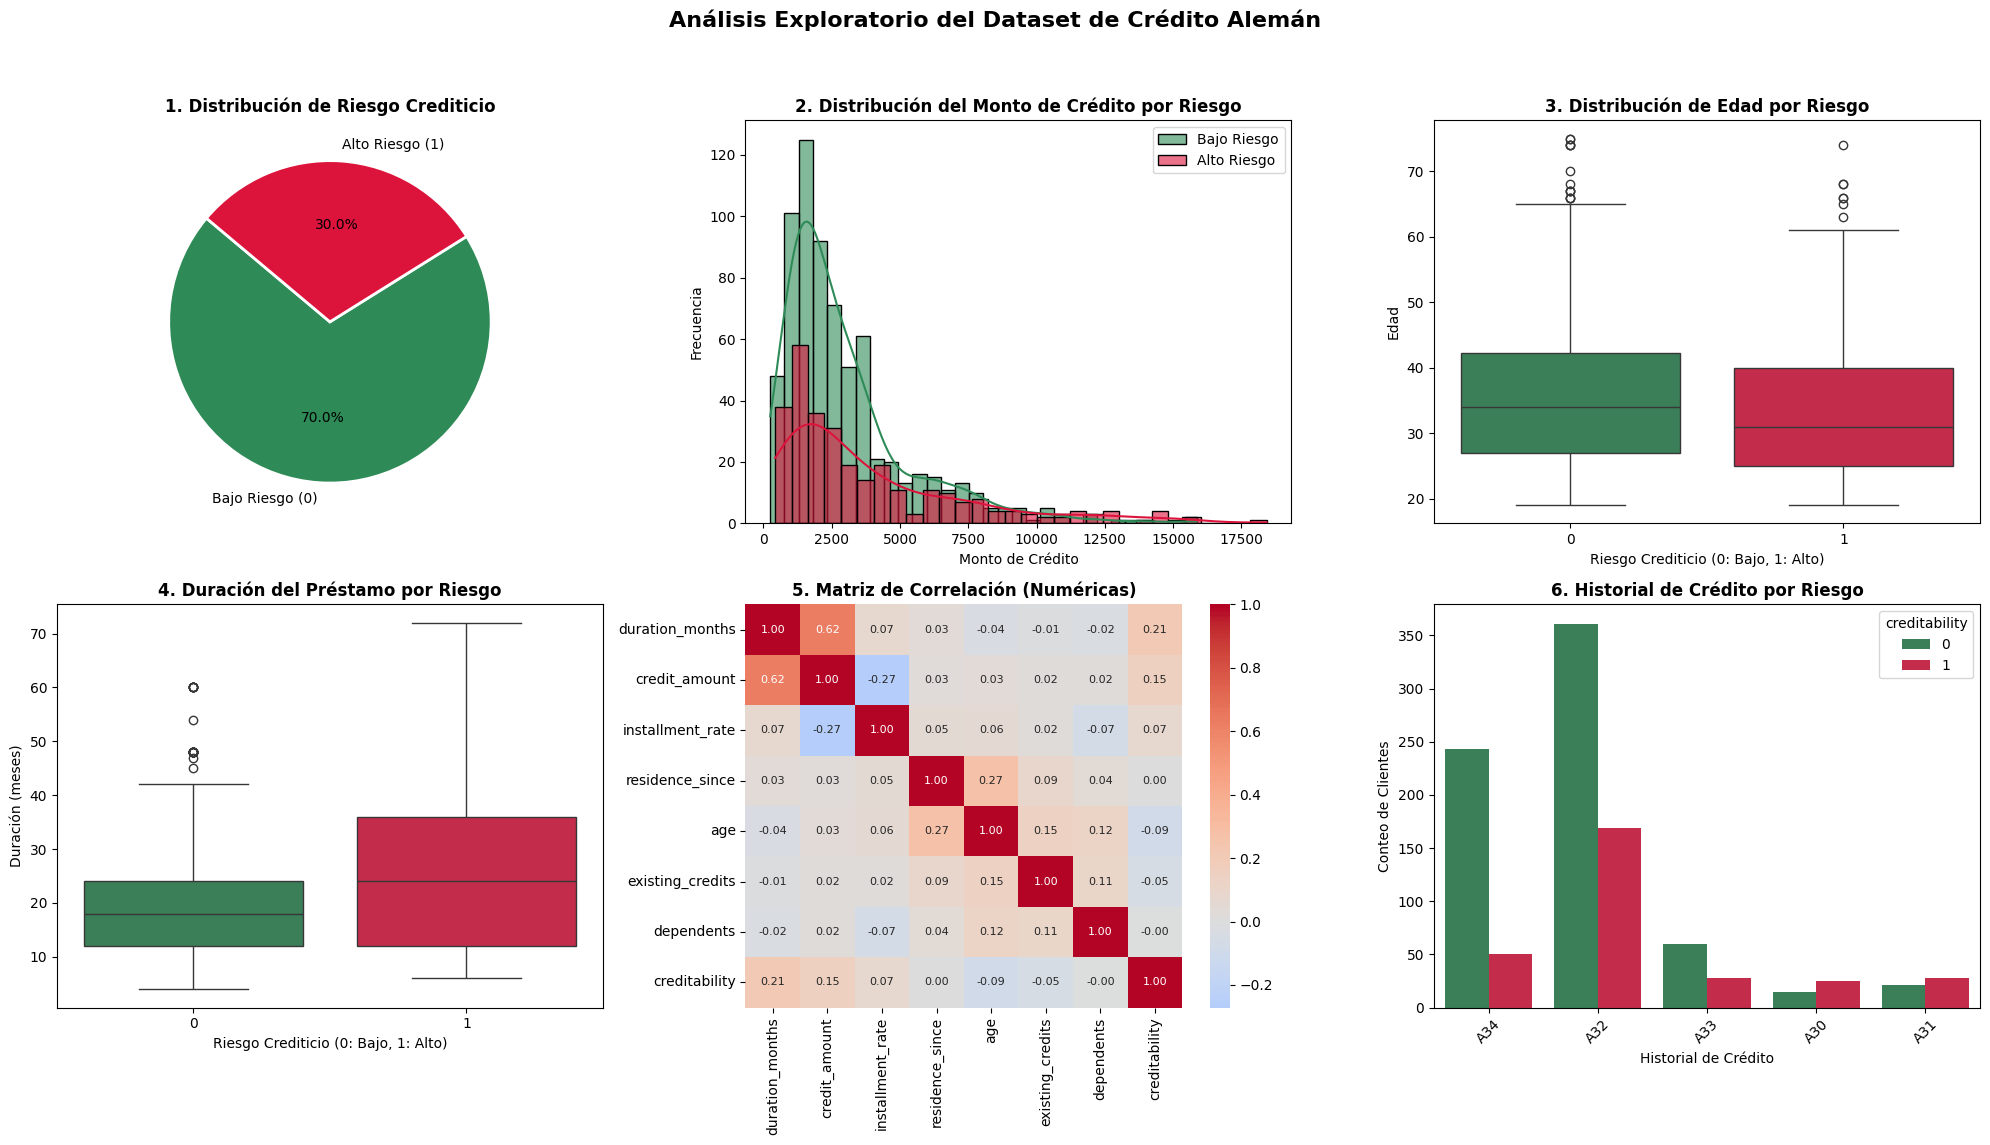

In [103]:
# =============================================================================
# 2.2. FUNCIÓN PARA VISUALIZACIÓN DE DATOS (EDA)
# =============================================================================

def create_comprehensive_visualizations(df):
    """
    Genera un panel de visualizaciones para realizar un análisis exploratorio
    completo y entender las relaciones clave en el dataset.

    Args:
        df (pd.DataFrame): El dataset a visualizar.
    """
    if df is None:
        print("El DataFrame está vacío. No se pueden generar visualizaciones.")
        return

    print("\n🎨 Generando visualizaciones para el Análisis Exploratorio de Datos (EDA)...")

    # Crear una figura con 6 subplots organizados en una grilla de 2x3
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Análisis Exploratorio del Dataset de Crédito Alemán', fontsize=16, fontweight='bold')

    # Paleta de colores para consistencia visual (verde para bajo riesgo, rojo para alto riesgo)
    colors = ['#2E8B57', '#DC143C']

    # --- Gráfico 1: Distribución de Riesgo Crediticio (Pie Chart) ---
    ax1 = axes[0, 0]
    counts = df['creditability'].value_counts()
    ax1.pie(counts.values, labels=['Bajo Riesgo (0)', 'Alto Riesgo (1)'],
            colors=colors, autopct='%1.1f%%', startangle=140,
            wedgeprops={'edgecolor': 'white', 'linewidth': 2})
    ax1.set_title('1. Distribución de Riesgo Crediticio', fontsize=12, fontweight='bold')

    # --- Gráfico 2: Distribución del Monto de Crédito por Riesgo ---
    ax2 = axes[0, 1]
    # Iterar para dibujar un histograma para cada clase de riesgo
    for risk, color, label in zip([0, 1], colors, ['Bajo Riesgo', 'Alto Riesgo']):
        subset = df[df['creditability'] == risk]['credit_amount']
        sns.histplot(subset, bins=30, alpha=0.6, color=color, label=label, ax=ax2, kde=True)
    ax2.set_title('2. Distribución del Monto de Crédito por Riesgo', fontweight='bold')
    ax2.set_xlabel('Monto de Crédito')
    ax2.set_ylabel('Frecuencia')
    ax2.legend()

    # --- Gráfico 3: Distribución de Edad por Riesgo Crediticio (Boxplot) ---
    ax3 = axes[0, 2]
    sns.boxplot(x='creditability', y='age', data=df, ax=ax3, palette=colors)
    ax3.set_title('3. Distribución de Edad por Riesgo', fontweight='bold')
    ax3.set_xlabel('Riesgo Crediticio (0: Bajo, 1: Alto)')
    ax3.set_ylabel('Edad')

    # --- Gráfico 4: Duración del Préstamo por Riesgo (Boxplot) ---
    ax4 = axes[1, 0]
    sns.boxplot(x='creditability', y='duration_months', data=df, ax=ax4, palette=colors)
    ax4.set_title('4. Duración del Préstamo por Riesgo', fontweight='bold')
    ax4.set_xlabel('Riesgo Crediticio (0: Bajo, 1: Alto)')
    ax4.set_ylabel('Duración (meses)')

    # --- Gráfico 5: Matriz de Correlación de Variables Numéricas ---
    ax5 = axes[1, 1]
    # Seleccionar solo las columnas numéricas para calcular la correlación
    numeric_cols = df.select_dtypes(include=np.number).columns
    corr_matrix = df[numeric_cols].corr()
    # Usar un mapa de calor para visualizar la matriz de correlación
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax5, fmt='.2f',
                annot_kws={"size": 8})
    ax5.set_title('5. Matriz de Correlación (Numéricas)', fontweight='bold')

    # --- Gráfico 6: Historial de Crédito por Riesgo ---
    ax6 = axes[1, 2]
    # Usar un countplot para ver la frecuencia del historial de crédito para cada clase de riesgo
    sns.countplot(x='credit_history', hue='creditability', data=df, ax=ax6, palette=colors)
    ax6.set_title('6. Historial de Crédito por Riesgo', fontweight='bold')
    ax6.set_xlabel('Historial de Crédito')
    ax6.set_ylabel('Conteo de Clientes')
    ax6.tick_params(axis='x', rotation=45) # Rotar etiquetas para mejor legibilidad

    # Ajustar el layout para evitar solapamientos y mostrar el gráfico
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para el título principal
    plt.show()

# Ejecutar la función de visualización
create_comprehensive_visualizations(df_credit)

### **Interpretación de los gráficos del Análisis Exploratorio de Datos (EDA) para el dataset de Crédito Alemán.**

***

### **Análisis General del Perfil de Riesgo Crediticio**

Este panel de visualizaciones ofrece una visión clara de las características que diferencian a los clientes de bajo y alto riesgo crediticio en el dataset. El análisis revela que la mayoría de los solicitantes (70%) son clasificados como de **bajo riesgo**. Las variables más influyentes parecen ser el **historial crediticio**, la **duración del préstamo** y el **monto del crédito**.

---

### **Interpretación Detallada por Gráfico**

A continuación, se desglosa el análisis de cada una de las visualizaciones:

#### **1. Distribución de Riesgo Crediticio**
El gráfico circular muestra una distribución desbalanceada en la variable objetivo. Un **70%** de los clientes en el dataset son de **bajo riesgo** (etiqueta 0), mientras que el **30%** restante es de **alto riesgo** (etiqueta 1). Este desequilibrio es un factor crucial a considerar durante el entrenamiento de modelos de machine learning, ya que podrían tender a predecir la clase mayoritaria.

---

#### **2. Distribución del Monto de Crédito por Riesgo**
Este histograma revela que los montos de crédito para clientes de **bajo riesgo** (verde) están más concentrados en valores bajos, con una rápida disminución a medida que el monto aumenta. En contraste, los clientes de **alto riesgo** (rojo), aunque también solicitan mayoritariamente montos bajos, muestran una distribución más extendida hacia montos más altos. Esto sugiere que los préstamos de mayor valor están asociados con un mayor riesgo de impago.

---

#### **3. Distribución de Edad por Riesgo**
Los diagramas de caja indican que la mediana de edad es ligeramente superior en el grupo de **bajo riesgo**. Sin embargo, la distribución de edades es bastante similar entre ambos grupos. El grupo de bajo riesgo presenta una mayor dispersión en las edades más altas. En general, la edad no parece ser un factor fuertemente diferenciador por sí sola para determinar el riesgo crediticio.

---

#### **4. Duración del Préstamo por Riesgo**
Aquí se observa una diferencia significativa. Los préstamos otorgados a clientes de **bajo riesgo** tienden a tener una **duración menor** (mediana alrededor de 18 meses). Por el contrario, los clientes de **alto riesgo** están asociados con préstamos de **mayor duración** (mediana cercana a 24 meses). Esto indica una correlación positiva: a mayor plazo del préstamo, mayor es la probabilidad de que el cliente sea clasificado como de alto riesgo.

---

#### **5. Matriz de Correlación (Numéricas)**
El mapa de calor muestra las relaciones lineales entre las variables numéricas. Las correlaciones más importantes son:
* **Monto del crédito (`credit_amount`) y Duración (`duration_months`):** Existe una correlación positiva fuerte (0.62). Esto es lógico, ya que los préstamos más grandes suelen requerir plazos más largos para su pago.
* **Credibilidad (`creditability`) y Duración:** Hay una correlación positiva (0.21), confirmando lo visto en el gráfico 4: duraciones más largas se asocian con mayor riesgo.
* **Credibilidad y Monto del crédito:** También se observa una correlación positiva (0.15), lo que refuerza que montos más altos tienden a asociarse con un riesgo mayor.

---

#### **6. Historial de Crédito por Riesgo**
Este es uno de los gráficos más reveladores. El historial de crédito es un predictor muy potente, pero de una manera más sutil de lo que parece:

1. **Indicador de Bajo Riesgo**: El historial 'A34' y 'A32' son los mejores indicadores de un cliente de bajo riesgo, ya que la gran mayoría de las personas en estas categorías cumplen con sus pagos.

2. **Indicador de Alto Riesgo (Probabilístico)**: Paradójicamente, tener un historial "demasiado bueno" o inexistente ('A30' y 'A31') se asocia con una mayor proporción de riesgo. Esto podría deberse a que el banco tiene menos datos sobre el comportamiento de pago de estos clientes, considerándolos una incógnita y, por tanto, más riesgosos.

## **2. Preprocesamiento Avanzado e Ingeniería de Características**

El preprocesamiento es una fase crítica en cualquier proyecto de Machine Learning, especialmente con datos tabulares. Un buen preprocesamiento puede mejorar significativamente el rendimiento del modelo.

Nuestra estrategia de preprocesamiento se divide en tres pasos principales:

1.  **Codificación de Variables Categóricas:**

      - Las redes neuronales solo pueden procesar datos numéricos. Por lo tanto, debemos convertir las variables categóricas (como 'purpose' o 'housing') en números.
      - Utilizaremos `LabelEncoder`, una técnica sencilla y efectiva que asigna un número entero único a cada categoría de una variable.

2.  **Ingeniería de Características (Feature Engineering):**

      - Este es el proceso de crear nuevas variables (características) a partir de las existentes para ayudar al modelo a encontrar patrones más complejos.
      - Crearemos ratios financieros (ej. `monto_credito / duracion`), interacciones entre variables (ej. `monto * duracion`), y variables indicadoras (ej. si una persona es joven o si un préstamo es a largo plazo). Estas nuevas características a menudo contienen información más rica que las originales.

3.  **Escalado de Características:**

      - Las variables numéricas suelen tener rangos muy diferentes (ej. la edad va de 19 a 75, mientras que el monto del crédito puede llegar a miles). Si no se escalan, las variables con rangos más grandes pueden dominar el proceso de aprendizaje.
      - Usaremos `RobustScaler`. A diferencia del `StandardScaler` más común, el `RobustScaler` utiliza la mediana y los cuantiles, lo que lo hace mucho más resistente (robusto) a la presencia de valores atípicos (outliers) en los datos.

Estos pasos se encapsularán en una clase `OptimizedPreprocessor` para mantener el código organizado y reutilizable.



In [104]:
# =============================================================================
# 3.1. CLASE PARA PREPROCESAMIENTO OPTIMIZADO
# =============================================================================

class OptimizedPreprocessor:
    """
    Una clase para encapsular todo el flujo de preprocesamiento de datos.
    Esto incluye codificación, ingeniería de características y escalado.
    """

    def __init__(self):
        """
        Constructor de la clase. Inicializa los objetos necesarios.
        """
        # RobustScaler es elegido por su resistencia a outliers.
        self.scaler = RobustScaler()
        # Un diccionario para almacenar los codificadores de etiquetas para cada variable categórica.
        self.label_encoders = {}
        # Una lista para guardar los nombres finales de las características después del preprocesamiento.
        self.feature_names = None
        # Una bandera para saber si el preprocesador ya ha sido "ajustado" con datos.
        self.is_fitted = False

    def fit_transform(self, df, target_col='creditability'):
        """
        Ajusta el preprocesador a los datos y los transforma.
        Este método se usa en el conjunto de entrenamiento.

        Args:
            df (pd.DataFrame): El DataFrame de entrenamiento.
            target_col (str): El nombre de la columna objetivo.

        Returns:
            tuple: Una tupla conteniendo (X_processed, y, feature_names).
        """
        print("\n🔄 Iniciando el preprocesamiento optimizado de datos...")

        # Separar las características (X) de la variable objetivo (y)
        X = df.drop(target_col, axis=1).copy()
        y = df[target_col].copy()

        # Identificar automáticamente las columnas numéricas y categóricas
        numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
        print(f"   - {len(numeric_cols)} variables numéricas identificadas.")
        print(f"   - {len(categorical_cols)} variables categóricas identificadas.")

        # --- Paso 1: Codificación de variables categóricas ---
        print("   - Aplicando Label Encoding a las variables categóricas...")
        for col in categorical_cols:
            le = LabelEncoder()
            # Ajustar y transformar la columna. Se convierte a string para asegurar compatibilidad.
            X[col] = le.fit_transform(X[col].astype(str))
            # Guardar el codificador para poder usarlo después en los datos de prueba.
            self.label_encoders[col] = le

        # --- Paso 2: Ingeniería de características mejorada ---
        print("   - Creando nuevas características (Feature Engineering)...")
        X = self._enhanced_feature_engineering(X)

        # Guardar los nombres de todas las características (originales + nuevas)
        self.feature_names = X.columns.tolist()

        # --- Paso 3: Escalado robusto de características ---
        print("   - Aplicando RobustScaler para normalizar las características...")
        # Ajustar el escalador a los datos y transformarlos.
        # El resultado es un array de numpy, así que lo convertimos de nuevo a DataFrame.
        X_processed = pd.DataFrame(
            self.scaler.fit_transform(X),
            columns=self.feature_names,
            index=X.index
        )

        # Marcar el preprocesador como ajustado.
        self.is_fitted = True

        print(f"✅ Preprocesamiento completo. El dataset ahora tiene {X_processed.shape[1]} características.")

        return X_processed, y, self.feature_names

    def _enhanced_feature_engineering(self, X):
        """
        Método privado para crear un conjunto de características adicionales y relevantes.

        Args:
            X (pd.DataFrame): DataFrame con características codificadas.

        Returns:
            pd.DataFrame: DataFrame con las nuevas características añadidas.
        """
        X = X.copy() # Trabajar sobre una copia para evitar advertencias de pandas

        # Añadir un pequeño epsilon para evitar divisiones por cero
        epsilon = 1e-8

        # Ratios financieros
        X['monthly_payment_ratio'] = X['credit_amount'] / (X['duration_months'] + epsilon)
        X['amount_duration_interaction'] = X['credit_amount'] * X['duration_months']
        X['credit_to_age_ratio'] = X['credit_amount'] / (X['age'] + epsilon)

        # Indicadores categóricos basados en edad
        X['age_group_young'] = (X['age'] < 25).astype(int)
        X['age_group_middle'] = ((X['age'] >= 25) & (X['age'] <= 50)).astype(int)
        X['age_group_senior'] = (X['age'] > 50).astype(int)

        # Indicadores categóricos basados en duración del préstamo
        X['short_term'] = (X['duration_months'] <= 12).astype(int)
        X['medium_term'] = ((X['duration_months'] > 12) & (X['duration_months'] <= 36)).astype(int)
        X['long_term'] = (X['duration_months'] > 36).astype(int)

        # Indicadores basados en cuantiles del monto del crédito
        q25 = X['credit_amount'].quantile(0.25)
        q75 = X['credit_amount'].quantile(0.75)
        X['low_amount'] = (X['credit_amount'] <= q25).astype(int)
        X['high_amount'] = (X['credit_amount'] >= q75).astype(int)

        return X

# Instanciar y aplicar el preprocesador
preprocessor = OptimizedPreprocessor()
X_processed, y, feature_names = preprocessor.fit_transform(df_credit)

print("\n📋 Primeras 5 filas del dataset después del preprocesamiento:")
display(X_processed.head())

print(f"\n📋 Lista de las {len(feature_names)} características finales:")
print(feature_names)


🔄 Iniciando el preprocesamiento optimizado de datos...
   - 7 variables numéricas identificadas.
   - 13 variables categóricas identificadas.
   - Aplicando Label Encoding a las variables categóricas...
   - Creando nuevas características (Feature Engineering)...
   - Aplicando RobustScaler para normalizar las características...
✅ Preprocesamiento completo. El dataset ahora tiene 31 características.

📋 Primeras 5 filas del dataset después del preprocesamiento:


,checking_account,duration_months,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status,other_debtors,...,amount_duration_interaction,credit_to_age_ratio,age_group_young,age_group_middle,age_group_senior,short_term,medium_term,long_term,low_amount,high_amount
0,-0.333333,-1.0,1.0,0.333333,-0.441354,2.0,1.0,0.5,0.0,0.0,...,-0.409057,-0.584818,0.0,-1.0,1.0,1.0,-1.0,0.0,4.0,0.0
1,0.000000,2.5,0.0,0.333333,1.393114,0.0,0.0,-0.5,-1.0,0.0,...,3.032908,2.306821,1.0,-1.0,0.0,0.0,-1.0,1.0,0.0,4.0
2,0.666667,-0.5,1.0,1.333333,-0.085739,0.0,0.5,-0.5,0.0,0.0,...,-0.184999,-0.295397,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0
3,-0.333333,2.0,0.0,0.000000,2.133883,0.0,0.5,-0.5,0.0,2.0,...,3.593685,1.217316,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,4.0
4,-0.333333,0.5,0.5,-1.000000,0.978421,0.0,0.0,0.0,0.0,0.0,...,0.948117,0.265800,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,4.0



📋 Lista de las 31 características finales:
['checking_account', 'duration_months', 'credit_history', 'purpose', 'credit_amount', 'savings_account', 'employment_since', 'installment_rate', 'personal_status', 'other_debtors', 'residence_since', 'property', 'age', 'other_installments', 'housing', 'existing_credits', 'job', 'dependents', 'telephone', 'foreign_worker', 'monthly_payment_ratio', 'amount_duration_interaction', 'credit_to_age_ratio', 'age_group_young', 'age_group_middle', 'age_group_senior', 'short_term', 'medium_term', 'long_term', 'low_amount', 'high_amount']


### **Análisis del Proceso y Resultados de Preprocesamiento**

El script `OptimizedPreprocessor` ejecuta un flujo de trabajo de preprocesamiento de datos robusto y bien estructurado, preparando el dataset de crédito para ser utilizado en modelos de machine learning. La interpretación se puede dividir en el análisis de la metodología empleada y el resultado final.

---

### 1. Análisis de la Metodología 🧠

Las decisiones tomadas dentro de la clase revelan un enfoque metódico y consciente de los desafíos comunes en la preparación de datos:

* **Encapsulación en una Clase:** El uso de una clase (`OptimizedPreprocessor`) es una **excelente práctica de ingeniería de software**. Esto no solo organiza el código, sino que también guarda el "estado" del preprocesamiento (los `label_encoders` y el `scaler`). Esto es crucial para evitar la fuga de datos (*data leakage*), ya que permite aplicar exactamente las mismas transformaciones al conjunto de prueba que se aprendieron del conjunto de entrenamiento.

* **Manejo de Variables Categóricas:** Se utilizó **`LabelEncoder`**, que convierte cada categoría de texto en un número entero.
    * **Ventaja:** Es simple y no aumenta la dimensionalidad del dataset (a diferencia de One-Hot Encoding).
    * **Consideración importante:** Esta técnica crea una relación ordinal artificial (ej. `2 > 1 > 0`). Para modelos basados en árboles (como Random Forest o XGBoost), esto no suele ser un problema. Sin embargo, para modelos lineales (como Regresión Logística), el modelo podría interpretar erróneamente esta secuencia numérica como una escala de valor, lo cual podría afectar su rendimiento.

* **Ingeniería de Características (Feature Engineering) 💡:** Este es el paso más valioso del proceso. En lugar de usar solo los datos originales, se han creado **11 nuevas características** diseñadas para capturar relaciones más complejas y potencialmente más predictivas:
    * **Ratios Financieros (`monthly_payment_ratio`, `credit_to_age_ratio`):** Estas características contextualizan los valores absolutos. Un monto de crédito de 5000 no significa lo mismo para una persona de 25 años que para una de 60. Estos ratios ayudan al modelo a capturar esa perspectiva.
    * **Características de Interacción (`amount_duration_interaction`):** Capturan el efecto combinado de dos variables. Un crédito alto a largo plazo es probablemente más riesgoso que un crédito alto a corto plazo.
    * **Discretización (Binning):** La creación de grupos (`age_group_*`, `*_term`, `low/high_amount`) transforma variables continuas en categóricas. Esto es muy útil para que los modelos puedan capturar **relaciones no lineales**. Por ejemplo, el riesgo crediticio podría ser alto para los más jóvenes, bajo para los de mediana edad y volver a subir para los mayores, algo que una variable lineal de `edad` no capturaría fácilmente.

* **Escalado de Datos con `RobustScaler`:** La elección de `RobustScaler` en lugar de otros como `StandardScaler` o `MinMaxScaler` es deliberada e inteligente.
    * **Justificación:** `RobustScaler` utiliza la mediana y el rango intercuartílico (IQR) para escalar los datos. Esto lo hace **resistente a los valores atípicos (*outliers*)**, que son muy comunes en datos financieros (ej. montos de crédito o salarios inusualmente altos). Usar un escalador sensible a outliers podría distorsionar la escala de la mayoría de los datos.

---

### 2. Análisis del Resultado ✅

El output confirma que el proceso se ejecutó con éxito y nos da una idea clara del dataset transformado:

* **Expansión de Características:** El proceso partió de 20 características iniciales (7 numéricas y 13 categóricas) y finalizó con **31 características**. Este enriquecimiento es el resultado directo de la ingeniería de características.

* **Dataset Procesado:** La tabla `X_processed.head()` muestra un dataset **completamente numérico y normalizado**. Los valores no están en sus unidades originales (ej. euros, meses, años), sino en una escala común, centrada alrededor de cero. Esto es fundamental para que algoritmos sensibles a la escala (como SVM, Regresión Logística o redes neuronales) funcionen correctamente.

* **Lista Final de Características:** La lista final de 31 columnas confirma que tanto las variables originales (ya codificadas) como las 11 nuevas creadas forman parte del conjunto de datos final que se usará para entrenar el modelo.

El resultado es un dataset **optimizado y enriquecido**, listo para el modelado. El preprocesamiento no solo ha limpiado y estandarizado los datos, sino que también ha inyectado conocimiento del dominio a través de la ingeniería de características. Este paso es a menudo más importante que la elección del algoritmo final y sienta las bases para construir un modelo de predicción de riesgo crediticio preciso y robusto.

## **División de Datos y Manejo del Desbalance de Clases**

### **División Estratificada**

Antes de entrenar cualquier modelo, es imprescindible dividir nuestros datos en tres conjuntos:

1.  **Conjunto de Entrenamiento (Training set):** La mayor parte de los datos (60% en nuestro caso), utilizada para que el modelo aprenda los patrones.
2.  **Conjunto de Validación (Validation set):** Una porción de los datos (20%) que se utiliza durante el entrenamiento para ajustar hiperparámetros (como la tasa de aprendizaje) y para decidir cuándo detener el entrenamiento (`EarlyStopping`). No se usa para el aprendizaje de los pesos del modelo.
3.  **Conjunto de Prueba (Test set):** Una porción final de datos (20%) que el modelo no ha visto nunca. Se usa una sola vez al final para evaluar el rendimiento real y final del modelo en datos nuevos.

Utilizaremos una **división estratificada**, lo que significa que la proporción de buenos y malos pagadores será la misma en los tres conjuntos. Esto es crucial en datasets desbalanceados para asegurar que la evaluación sea representativa.

### **Manejo del Desbalance con SMOTE**

Como vimos en el EDA, nuestro dataset está desbalanceado (70% buenos pagadores, 30% malos). Si entrenamos un modelo con estos datos, podría volverse muy bueno prediciendo la clase mayoritaria (buenos pagadores) e ignorar casi por completo la clase minoritaria (malos pagadores), que es precisamente la que más nos interesa detectar.

Para solucionar esto, aplicaremos la técnica **SMOTE (Synthetic Minority Over-sampling Technique)**.

  - **¿Cómo funciona?** SMOTE no simplemente duplica las muestras de la clase minoritaria. En su lugar, crea nuevas muestras sintéticas que son combinaciones de las muestras existentes. Lo hace seleccionando una muestra de la clase minoritaria y generando nuevas muestras sintéticas a lo largo de las líneas que unen a esa muestra con sus vecinos más cercanos.
  - **Importante:** SMOTE se aplica **únicamente al conjunto de entrenamiento**. Los conjuntos de validación y prueba deben permanecer con la distribución original para reflejar la realidad del problema.

Este script implementa dos de los pasos más críticos y fundamentales en un proyecto de machine learning de clasificación: la **segmentación de datos** y el **manejo del desbalance de clases**. Las decisiones tomadas y los resultados obtenidos demuestran una aplicación rigurosa de las mejores prácticas, diseñadas para construir un modelo predictivo que sea a la vez preciso y generalizable a datos del mundo real.

In [105]:
# =============================================================================
# 4.1. DIVISIÓN DE DATOS Y MANEJO DE DESBALANCE
# =============================================================================

print("\n🔪 Dividiendo los datos en conjuntos de entrenamiento, validación y prueba...")

# --- Primera división: Separar el conjunto de prueba (20%) del resto ---
# 'stratify=y' asegura que la proporción de clases sea la misma en ambos conjuntos.
X_temp, X_test, y_temp, y_test = train_test_split(
    X_processed, y,
    test_size=0.2,       # 20% de los datos para el conjunto de prueba
    random_state=42,     # Semilla para reproducibilidad
    stratify=y           # Estratificar basado en la variable objetivo
)

# --- Segunda división: Separar el conjunto de entrenamiento (60%) y validación (20%) ---
# El 25% de X_temp (que es el 80% del total) corresponde al 20% del total original.
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,      # 25% de los datos temporales para validación
    random_state=42,     # Semilla para reproducibilidad
    stratify=y_temp      # Estratificar de nuevo
)

print("\n📊 Dimensiones de los conjuntos de datos:")
print(f"   - Entrenamiento: {X_train.shape[0]} muestras ({X_train.shape[0]/len(df_credit)*100:.0f}%)")
print(f"   - Validación:    {X_val.shape[0]} muestras ({X_val.shape[0]/len(df_credit)*100:.0f}%)")
print(f"   - Prueba:        {X_test.shape[0]} muestras ({X_test.shape[0]/len(df_credit)*100:.0f}%)")


# --- Manejo del desbalance de clases usando SMOTE ---
print("\n⚖️  Manejando el desbalance de clases en el conjunto de entrenamiento con SMOTE...")

# 'k_neighbors' debe ser menor que el número de muestras en la clase minoritaria.
# Calculamos un valor seguro para evitar errores.
n_minority_samples = y_train.value_counts().min()
k_neighbors = min(5, n_minority_samples - 1)

# Instanciar SMOTE
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)

# Aplicar SMOTE **solo** al conjunto de entrenamiento
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\n📊 Distribución de clases en el conjunto de entrenamiento ANTES de SMOTE:")
print(y_train.value_counts())
print("\n📊 Distribución de clases en el conjunto de entrenamiento DESPUÉS de SMOTE:")
print(y_train_balanced.value_counts())
print("   - Ahora las clases están perfectamente balanceadas, listas para el entrenamiento.")


🔪 Dividiendo los datos en conjuntos de entrenamiento, validación y prueba...

📊 Dimensiones de los conjuntos de datos:
   - Entrenamiento: 600 muestras (60%)
   - Validación:    200 muestras (20%)
   - Prueba:        200 muestras (20%)

⚖️  Manejando el desbalance de clases en el conjunto de entrenamiento con SMOTE...

📊 Distribución de clases en el conjunto de entrenamiento ANTES de SMOTE:
creditability
0    420
1    180
Name: count, dtype: int64

📊 Distribución de clases en el conjunto de entrenamiento DESPUÉS de SMOTE:
creditability
0    420
1    420
Name: count, dtype: int64
   - Ahora las clases están perfectamente balanceadas, listas para el entrenamiento.


### Interpretación de la Metodología 👨‍🔬

#### **División de Datos en Tres Conjuntos (Entrenamiento, Validación y Prueba)**

La estrategia de dividir los datos en tres conjuntos (60% entrenamiento, 20% validación, 20% prueba) es un estándar de oro en el desarrollo de modelos robustos. Cada conjunto tiene un propósito específico e inalterable:

* **Conjunto de Entrenamiento (`X_train`, `y_train`):** Es el único conjunto de datos que el modelo "ve" durante su aprendizaje. Se utiliza para que el algoritmo aprenda los patrones, relaciones y pesos de las características. La aplicación de SMOTE se realiza exclusivamente aquí.

* **Conjunto de Validación (`X_val`, `y_val`):** Este conjunto actúa como un "simulacro de examen". Se utiliza para **ajustar los hiperparámetros del modelo** (por ejemplo, la complejidad de un árbol de decisión o la tasa de aprendizaje de un algoritmo de boosting) y para **seleccionar el mejor modelo** entre varios candidatos. Es crucial que este conjunto no se use para entrenar ni se le aplique SMOTE, ya que su objetivo es evaluar de manera imparcial el rendimiento del modelo durante la fase de desarrollo.

* **Conjunto de Prueba (`X_test`, `y_test`):** Este es el "examen final". Es un conjunto de datos completamente nuevo para el modelo, que se mantiene intacto y se usa **una sola vez** al final del proceso para obtener una métrica final e imparcial del rendimiento del modelo. Simula cómo se comportaría el modelo en un entorno de producción con datos nunca antes vistos.

#### **Uso de Estratificación (`stratify=y`)**

Esta es una decisión metodológica clave. Al estratificar, la función `train_test_split` asegura que la proporción original de clases (70% bajo riesgo, 30% alto riesgo) se **mantenga constante** en los conjuntos de entrenamiento, validación y prueba. Sin la estratificación, por puro azar, el conjunto de prueba podría terminar con una proporción de clases muy diferente a la del conjunto de entrenamiento, lo que llevaría a una evaluación del rendimiento poco fiable.

#### **Manejo del Desbalance con SMOTE (Synthetic Minority Over-sampling Technique)**

El desbalance de clases, donde una clase es mucho más frecuente que otra (420 vs 180 en los datos de entrenamiento), es un problema común. Si no se trata, el modelo tiende a volverse "perezoso", obteniendo una alta precisión simplemente prediciendo siempre la clase mayoritaria.

* **¿Por qué SMOTE?** SMOTE es una técnica sofisticada. En lugar de simplemente duplicar las muestras de la clase minoritaria (lo que podría llevar al sobreajuste), SMOTE crea **nuevas muestras sintéticas**. Lo hace seleccionando una muestra de la clase minoritaria, encontrando sus vecinos más cercanos de la misma clase y generando un nuevo punto de datos en el espacio de características entre el punto original y sus vecinos. El resultado es un conjunto de datos de entrenamiento más rico y diverso para la clase minoritaria.

* **Aplicación Exclusiva al Conjunto de Entrenamiento:** Esta es la regla más importante del sobremuestreo. Los conjuntos de validación y prueba **deben permanecer en su estado original y desbalanceado**, ya que representan la realidad. El objetivo es entrenar un modelo que aprenda a identificar patrones en un entorno balanceado, pero que luego sea evaluado en su capacidad para desempeñarse en el mundo real, que es inherentemente desbalanceado.

---

### Interpretación de los Resultados 📊

Los resultados del script confirman que la metodología se aplicó correctamente:

* **Dimensiones de los Conjuntos:** Las dimensiones son exactamente las esperadas: 600, 200 y 200 muestras, validando la división 60/20/20.

* **Distribución de Clases ANTES de SMOTE:** El conteo de valores en `y_train` (420 para la clase 0 y 180 para la clase 1) muestra claramente el desbalance de clases original, con una proporción aproximada de 7 a 3.

* **Distribución de Clases DESPUÉS de SMOTE:** El conteo de valores en `y_train_balanced` muestra un equilibrio perfecto: **420 muestras para la clase 0 y 420 para la clase 1**. Esto indica que SMOTE generó exitosamente 240 nuevas muestras sintéticas de la clase minoritaria (420 - 180 = 240), preparando un terreno de juego nivelado para que el modelo aprenda sin sesgos hacia la clase mayoritaria.

El proceso ejecutado ha preparado los datos de manera impecable para la fase de modelado. Se ha asegurado la **reproducibilidad** (`random_state`), se ha garantizado una **evaluación justa** mediante una división estratificada en tres conjuntos, y se ha mitigado proactivamente el **sesgo del modelo** a través de una aplicación correcta de SMOTE. El proyecto está ahora en una posición ideal para entrenar y evaluar modelos de machine learning de alto rendimiento.

## **3. Construcción de los Modelos de Redes Neuronales**

Ahora construiremos dos arquitecturas de redes neuronales profundas para comparar su rendimiento en este problema de datos tabulares.

### **Modelo 1: Red Neuronal Densa Optimizada (DNN)**

Esta será nuestra primera arquitectura. Aunque se la considera "simple" en comparación con la ResNet, está cuidadosamente diseñada con las mejores prácticas:

  - **Capas `Dense`:** Son las capas fundamentales de una red neuronal, donde cada neurona está conectada a todas las neuronas de la capa anterior.
  - **Funciones de Activación `ReLU`:** Introducen no-linealidad, permitiendo al modelo aprender relaciones complejas.
  - **`BatchNormalization`:** Normaliza la salida de cada capa. Esto estabiliza y acelera enormemente el entrenamiento.
  - **`Dropout`:** Es una técnica de regularización clave para prevenir el sobreajuste (overfitting). Durante el entrenamiento, "apaga" aleatoriamente un porcentaje de neuronas, forzando a la red a aprender representaciones más robustas.
  - **Regularización L1/L2:** Añade una penalización a la función de pérdida basada en la magnitud de los pesos de la red, ayudando a mantener los pesos pequeños y previniendo el sobreajuste.
  - **Capa de Salida `Sigmoid`:** Para problemas de clasificación binaria, la capa de salida utiliza una activación sigmoide, que produce un valor entre 0 y 1, interpretable como la probabilidad de pertenecer a la clase positiva (en nuestro caso, "alto riesgo").

### **Modelo 2: Red Residual (ResNet) para Datos Tabulares**

Las ResNets, originalmente famosas en visión por computadora, pueden adaptarse para datos tabulares. Su innovación clave son las **"conexiones residuales" (skip connections)**.

  - **¿Qué es una conexión residual?** Permite que la entrada de un bloque de capas "salte" ese bloque y se sume directamente a su salida.
  - **¿Por qué es útil?** A medida que las redes se hacen más profundas, pueden sufrir el problema del "gradiente desvaneciente", donde la señal de error se debilita al retropropagar, dificultando el aprendizaje. Las conexiones residuales proporcionan un camino directo para el gradiente, permitiendo entrenar redes mucho más profundas y complejas de manera efectiva. Esto ayuda al modelo a aprender si una capa es necesaria o si es mejor simplemente pasar la información original.

Compararemos estas dos arquitecturas para ver si la complejidad adicional de la ResNet proporciona una ventaja en nuestro problema de scoring crediticio.



In [106]:
# =============================================================================
# 5.1. CLASE PARA EL MODELO DNN OPTIMIZADO
# =============================================================================

class OptimizedDNNModel:
    """
    Define, construye y entrena una Red Neuronal Densa (DNN) optimizada.
    """

    def __init__(self, input_dim, learning_rate=0.001):
        """
        Constructor.

        Args:
            input_dim (int): El número de características de entrada.
            learning_rate (float): La tasa de aprendizaje para el optimizador.
        """
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.model = None # El modelo se creará con el método build_model

    def build_model(self):
        """
        Construye la arquitectura de la red neuronal usando la API Secuencial de Keras.
        """
        # Definición secuencial de las capas del modelo
        model = tf.keras.models.Sequential([
            # Capa de entrada con el número de características
            Input(shape=(self.input_dim,)),

            # Capa de ruido gaussiano: una forma de regularización que añade ruido
            # a los datos de entrada, haciendo el modelo más robusto.
            GaussianNoise(0.05),

            # --- Bloque 1 ---
            Dense(128, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)), # Capa densa con 128 neuronas y regularización
            BatchNormalization(),                                    # Normalización para estabilizar el entrenamiento
            Activation('relu'),                                      # Función de activación no lineal
            Dropout(0.3),                                            # Dropout para prevenir sobreajuste

            # --- Bloque 2 ---
            Dense(64, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            BatchNormalization(),
            Activation('relu'),
            Dropout(0.3),

            # --- Bloque 3 ---
            Dense(32, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            BatchNormalization(),
            Activation('relu'),
            Dropout(0.2),

            # --- Capa de Salida ---
            # Una sola neurona con activación sigmoide para predicción de probabilidad (0 a 1)
            Dense(1, activation='sigmoid', name='risk_prediction')
        ])

        # Compilar el modelo
        model.compile(
            optimizer=Adam(learning_rate=self.learning_rate), # Optimizador Adam, muy popular y efectivo
            loss='binary_crossentropy',                       # Función de pérdida para clasificación binaria
            metrics=['accuracy', AUC(name='auc')]             # Métricas para monitorear durante el entrenamiento
        )

        self.model = model
        return self.model

# =============================================================================
# 5.2. CLASE PARA EL MODELO RESNET AVANZADO
# =============================================================================

class AdvancedResNetModel:
    """
    Define, construye y entrena una Red Residual (ResNet) adaptada para datos tabulares.
    """

    def __init__(self, input_dim, learning_rate=0.001):
        """
        Constructor.

        Args:
            input_dim (int): El número de características de entrada.
            learning_rate (float): La tasa de aprendizaje para el optimizador.
        """
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.model = None

    def _residual_block(self, x, units, dropout_rate=0.3):
        """
        Define un bloque residual con una conexión de salto (skip connection).

        Args:
            x: Tensor de entrada al bloque.
            units (int): Número de neuronas en las capas densas del bloque.
            dropout_rate (float): Tasa de dropout a aplicar.

        Returns:
            Tensor de salida del bloque.
        """
        # Guardar la entrada para la conexión de salto
        shortcut = x

        # Primera transformación dentro del bloque
        out = LayerNormalization()(x) # Normalización por capa, alternativa a BatchNormalization
        out = Activation('relu')(out)
        out = Dense(units, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(out)

        # Segunda transformación
        out = LayerNormalization()(out)
        out = Activation('relu')(out)
        out = Dropout(dropout_rate)(out)
        out = Dense(units, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(out)

        # Si las dimensiones de la entrada y la salida del bloque no coinciden,
        # se proyecta la entrada (shortcut) para que tengan la misma dimensión.
        if shortcut.shape[-1] != units:
            shortcut = Dense(units)(shortcut)

        # La conexión residual: se suma la entrada original (shortcut) a la salida de las transformaciones
        out = Add()([shortcut, out])

        return out

    def build_model(self):
        """
        Construye la arquitectura ResNet usando la API Funcional de Keras.
        """
        # Definir la capa de entrada
        inputs = Input(shape=(self.input_dim,), name='input_features')

        # Capa inicial para procesar la entrada antes de los bloques residuales
        x = Dense(128, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(inputs)

        # Apilar bloques residuales
        x = self._residual_block(x, 128, dropout_rate=0.3)
        x = self._residual_block(x, 128, dropout_rate=0.3)
        x = self._residual_block(x, 64, dropout_rate=0.2)

        # Capas finales después de los bloques residuales
        x = LayerNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(0.2)(x)

        # Capa de salida
        outputs = Dense(1, activation='sigmoid', name='risk_prediction')(x)

        # Crear y compilar el modelo
        self.model = Model(inputs=inputs, outputs=outputs, name='AdvancedResNet')
        self.model.compile(
            optimizer=Adam(learning_rate=self.learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy', AUC(name='auc')]
        )
        return self.model

# Mensaje de confirmación
print("✅ Clases de modelo DNN y ResNet definidas correctamente.")

✅ Clases de modelo DNN y ResNet definidas correctamente.


### **Análisis General de las Arquitecturas de Modelo**

El código define dos clases, `OptimizedDNNModel` y `AdvancedResNetModel`, que encapsulan la construcción de dos arquitecturas de redes neuronales distintas para una tarea de clasificación binaria (como la predicción de riesgo crediticio). Ambas implementaciones demuestran un alto nivel de madurez técnica, incorporando múltiples técnicas modernas para maximizar el rendimiento y prevenir el sobreajuste.

La estrategia general parece ser comparar un modelo de Red Neuronal Densa (DNN) profundo y bien regularizado contra una arquitectura más avanzada de Red Residual (ResNet), que es un estándar en el campo de la visión por computadora pero que ha sido adaptada aquí de manera inteligente para datos tabulares.

---

### `OptimizedDNNModel`: Un Enfoque Robusto y Convencional 🧠

Esta clase construye una red neuronal secuencial "clásica", pero la fortalece con un conjunto de técnicas de regularización y estabilización que la convierten en un modelo base muy potente.

* **Arquitectura Piramidal:** El modelo sigue una estructura de cono o pirámide (128 → 64 → 32 neuronas). Este es un diseño común que busca forzar a la red a aprender representaciones de datos cada vez más abstractas y comprimidas a medida que la información fluye a través de las capas.

* **Bloques de Construcción Modernos:** Cada bloque de la red sigue una receta probada y efectiva:
    1.  **`Dense`:** La capa principal que realiza la transformación lineal y aprende los patrones.
    2.  **`BatchNormalization`:** Estabiliza y acelera significativamente el entrenamiento al normalizar las salidas de la capa anterior. Esto combate el problema del "cambio covariante interno" y permite usar tasas de aprendizaje más altas.
    3.  **`Activation('relu')`:** Introduce la no linealidad necesaria para que el modelo aprenda relaciones complejas.
    4.  **`Dropout`:** Una técnica de regularización fundamental. Durante el entrenamiento, "apaga" aleatoriamente un porcentaje de neuronas, lo que obliga a la red a aprender rutas de conocimiento redundantes y le impide depender en exceso de neuronas específicas. Esto mejora enormemente su capacidad de generalización a datos nuevos.

* **Estrategias de Regularización Múltiples:** El modelo no depende de una sola técnica para combatir el sobreajuste, sino que combina varias:
    * **`GaussianNoise`:** Actúa como una forma de aumento de datos para datos tabulares, añadiendo un ligero ruido a la entrada. Esto hace que el modelo sea más robusto y menos sensible a pequeñas variaciones en los datos de entrada.
    * **`l1_l2` Regularization:** Aplica una penalización a la función de pérdida basada en el tamaño de los pesos del modelo. Esto desincentiva los pesos grandes y complejos, promoviendo modelos más simples y generalizables.
    * **`Dropout`:** Como se mencionó, previene la co-adaptación compleja de las neuronas.

* **Capa de Salida y Compilación:** La capa final con **`Dense(1, activation='sigmoid')`** es la elección estándar y correcta para la clasificación binaria, ya que produce una probabilidad entre 0 y 1. La compilación con el optimizador **`Adam`** y la función de pérdida **`binary_crossentropy`** también es el estándar de oro para este tipo de problema. La inclusión de la métrica **AUC** es particularmente importante, ya que es una medida de rendimiento mucho más fiable que la exactitud (`accuracy`) en problemas con clases desbalanceadas.

---

### `AdvancedResNetModel`: Un Enfoque de Vanguardia 🚀

Esta clase implementa una Red Residual (ResNet), una arquitectura que revolucionó el deep learning. Su adaptación para datos tabulares es una aproximación sofisticada que busca resolver uno de los problemas clave de las redes muy profundas.

* **El Bloque Residual (`_residual_block`):** Esta es la innovación central de la ResNet. En lugar de esperar que una pila de capas aprenda directamente una transformación compleja, el bloque residual aprende la "diferencia" o el "residuo" entre la entrada y la transformación deseada.
    * **Conexiones de Salto (*Skip Connections*):**  La línea `out = Add()([shortcut, out])` es el corazón del bloque. Permite que la entrada original (`shortcut`) "salte" varias capas y se sume directamente a su salida.
    * **¿Por qué es tan potente?** Esto resuelve el "problema de degradación", donde añadir más capas a una red profunda puede empeorar el rendimiento. Las conexiones de salto facilitan el flujo de gradientes durante el entrenamiento, permitiendo construir redes mucho más profundas sin que se desvanezca la señal de aprendizaje. Si una capa no es útil, la red puede aprender fácilmente a ignorarla (haciendo que su contribución sea cero) y simplemente dejar pasar la información a través de la conexión de salto.

* **API Funcional de Keras:** A diferencia del modelo secuencial, la ResNet requiere la API Funcional (`Model(inputs=..., outputs=...)`). Esto es necesario para construir arquitecturas no lineales donde las capas pueden tener múltiples entradas y salidas, como es el caso de las conexiones de salto.

* **`LayerNormalization`:** Este modelo utiliza `LayerNormalization` en lugar de `BatchNormalization`. Es una alternativa que normaliza las entradas a través de las características en lugar de a través del lote. Puede ofrecer un rendimiento más estable, especialmente con tamaños de lote pequeños, y es una opción común en arquitecturas modernas como los Transformers.

El resultado `✅ Clases de modelo DNN y ResNet definidas correctamente` confirma que el código es sintácticamente correcto y que las dos arquitecturas de modelo están listas para ser instanciadas y entrenadas.

La definición de estos dos modelos representa una estrategia de modelado muy completa. El **`OptimizedDNNModel` sirve como un baseline extremadamente fuerte y bien diseñado**. El **`AdvancedResNetModel` es un competidor avanzado** que plantea la hipótesis de que una arquitectura más profunda y compleja, habilitada por bloques residuales, podría capturar patrones de datos aún más sutiles y, en última instancia, superar al modelo DNN.



## **Entrenamiento de los Modelos**

El proceso de entrenamiento consiste en alimentar el modelo con el `X_train_balanced` y `y_train_balanced` para que ajuste sus pesos internos y aprenda a mapear las características de entrada a la probabilidad de impago.

Para asegurar un entrenamiento robusto y eficiente, utilizaremos dos **callbacks** importantes de Keras:

1.  **`EarlyStopping` (Parada Temprana):**

      - **Propósito:** Prevenir el sobreajuste y ahorrar tiempo de computación.
      - **Funcionamiento:** Monitorea una métrica en el conjunto de validación (en nuestro caso, el `val_auc`). Si esta métrica deja de mejorar durante un número determinado de épocas (`patience`), el entrenamiento se detiene automáticamente. La opción `restore_best_weights=True` asegura que el modelo final que obtengamos sea el que tuvo el mejor rendimiento en la validación, y no el del último paso.

2.  **`ReduceLROnPlateau` (Reducción de Tasa de Aprendizaje en Meseta):**

      - **Propósito:** Afinar el proceso de aprendizaje.
      - **Funcionamiento:** También monitorea la métrica de validación (`val_auc`). Si la métrica se estanca (entra en una "meseta"), este callback reduce la tasa de aprendizaje (`learning rate`). La idea es que, al principio, una tasa de aprendizaje alta permite avances rápidos, pero cerca del óptimo, pasos más pequeños (una tasa de aprendizaje menor) son necesarios para no "pasarse de largo".

A continuación, instanciaremos y entrenaremos ambos modelos, la DNN y la ResNet, utilizando estos callbacks.


In [107]:
# =============================================================================
# 6.1. ENTRENAMIENTO DEL MODELO DNN OPTIMIZADO
# =============================================================================

print("\n🔧 === ENTRENANDO MODELO DNN OPTIMIZADO ===")

# Obtener la dimensión de entrada del shape del dataframe de entrenamiento
input_dim = X_train_balanced.shape[1]

# Instanciar el modelo
dnn_builder = OptimizedDNNModel(input_dim=input_dim, learning_rate=0.001)
dnn_model = dnn_builder.build_model()

# Mostrar un resumen de la arquitectura del modelo
print("\n📋 Arquitectura del Modelo DNN Optimizado:")
dnn_model.summary()

# Definir los callbacks para el entrenamiento
dnn_callbacks = [
    # Detener el entrenamiento si 'val_auc' no mejora en 25 épocas
    EarlyStopping(
        monitor='val_auc',
        mode='max', # Buscamos maximizar el AUC
        patience=25,
        restore_best_weights=True,
        verbose=1
    ),
    # Reducir la tasa de aprendizaje si 'val_auc' se estanca
    ReduceLROnPlateau(
        monitor='val_auc',
        mode='max',
        factor=0.8, # Reducir LR a 80% del valor actual
        patience=10,
        min_lr=1e-7, # Tasa de aprendizaje mínima
        verbose=1
    )
]

# Entrenar el modelo
print("\n🚀 Iniciando entrenamiento DNN...")
dnn_history = dnn_model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val, y_val), # Datos de validación para monitorear el rendimiento
    epochs=150,                   # Número máximo de épocas
    batch_size=64,                # Tamaño del lote de datos en cada paso de entrenamiento
    callbacks=dnn_callbacks,      # Lista de callbacks a usar
    verbose=1                     # Mostrar progreso
)
print("✅ Entrenamiento del modelo DNN completado.")

# =============================================================================
# 6.2. ENTRENAMIENTO DEL MODELO RESNET AVANZADO
# =============================================================================

print("\n🔧 === ENTRENANDO MODELO RESNET AVANZADO ===")

# Instanciar el modelo
resnet_builder = AdvancedResNetModel(input_dim=input_dim, learning_rate=0.001)
resnet_model = resnet_builder.build_model()

# Mostrar un resumen de la arquitectura del modelo
print("\n📋 Arquitectura del Modelo ResNet Avanzado:")
resnet_model.summary()

# Definir los callbacks para el entrenamiento de la ResNet (paciencia ligeramente mayor)
resnet_callbacks = [
    EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=30, # Un poco más de paciencia para arquitecturas complejas
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_auc',
        mode='max',
        factor=0.7,
        patience=12,
        min_lr=1e-7,
        verbose=1
    )
]

# Entrenar el modelo
print("\n🚀 Iniciando entrenamiento ResNet...")
resnet_history = resnet_model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=64,
    callbacks=resnet_callbacks,
    verbose=1
)
print("✅ Entrenamiento del modelo ResNet completado.")


🔧 === ENTRENANDO MODELO DNN OPTIMIZADO ===

📋 Arquitectura del Modelo DNN Optimizado:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise_10               │ (None, 31)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 128)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_93 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_94 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_95 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ risk_prediction (Dense)         │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,361 (60.00 KB)

 Trainable params: 14,913 (58.25 KB)

 Non-trainable params: 448 (1.75 KB)


🚀 Iniciando entrenamiento DNN...
Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.5460 - auc: 0.5642 - loss: 0.7673 - val_accuracy: 0.6500 - val_auc: 0.6087 - val_loss: 0.6964 - learning_rate: 0.0010
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6370 - auc: 0.6581 - loss: 0.7063 - val_accuracy: 0.6350 - val_auc: 0.6254 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6632 - auc: 0.7100 - loss: 0.6566 - val_accuracy: 0.6350 - val_auc: 0.6490 - val_loss: 0.6822 - learning_rate: 0.0010
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7075 - auc: 0.7829 - loss: 0.5970 - val_accuracy: 0.6500 - val_auc: 0.6745 - val_loss: 0.6669 - learning_rate: 0.0010
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7163 - auc: 0.7982 - loss: 0.5782 - val_accuracy: 0.6400 - val_auc: 0.6828 - val_loss: 0.6553 - learning_rate: 0.0010
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36

Model: "AdvancedResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features      │ (None, 31)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_105 (Dense)   │ (None, 128)       │      4,096 │ input_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_105[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 128)       │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_106 (Dense)   │ (None, 128)       │     16,512 │ activation_96[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_106[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 128)       │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_69          │ (None, 128)       │          0 │ activation_97[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_107 (Dense)   │ (None, 128)       │     16,512 │ dropout_69[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_27 (Add)        │ (None, 128)       │          0 │ dense_105[0][0],  │
│                     │                   │            │ dense_107[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ add_27[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 128)       │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_108 (Dense)   │ (None, 128)       │     16,512 │ activation_98[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_108[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_99       │ (None, 128)       │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_70          │ (None, 128)       │          0 │ activation_99[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_109 (Dense)   │ (None, 128)       │     16,512 │ dropout_70[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_28 (Add)        │ (None, 128)       │          0 │ add_27[0][0],     │
│                     │                   │            │ dense_109[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 92,417 (361.00 KB)

 Trainable params: 92,417 (361.00 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Iniciando entrenamiento ResNet...
Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 65s 112ms/step - accuracy: 0.5356 - auc: 0.5663 - loss: 0.9035 - val_accuracy: 0.6600 - val_auc: 0.6994 - val_loss: 0.7193 - learning_rate: 0.0010
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7099 - auc: 0.7781 - loss: 0.7064 - val_accuracy: 0.6350 - val_auc: 0.7236 - val_loss: 0.8122 - learning_rate: 0.0010
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7246 - auc: 0.8220 - loss: 0.6567 - val_accuracy: 0.6050 - val_auc: 0.7251 - val_loss: 0.9333 - learning_rate: 0.0010
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7580 - auc: 0.8476 - loss: 0.6396 - val_accuracy: 0.6400 - val_auc: 0.7315 - val_loss: 0.9309 - learning_rate: 0.0010
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7578 - auc: 0.8598 - loss: 0.6278 - val_accuracy: 0.6450 - val_auc: 0.7335 - val_loss: 0.8615 - learning_rate: 0.0010
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s

## **4. Evaluación Integral y Comparación de Modelos**

Una vez que los modelos han sido entrenados, debemos evaluar su rendimiento de manera rigurosa utilizando el **conjunto de prueba**, que han permanecido intactos hasta ahora.

### **Estrategia de Evaluación**

Nuestra evaluación irá más allá de la simple exactitud (`accuracy`). En un problema desbalanceado como el scoring crediticio, la exactitud puede ser engañosa. Por ello, nos centraremos en un conjunto de métricas más informativas:

  - **Matriz de Confusión:** Una tabla que desglosa las predicciones en Verdaderos Positivos (TP), Verdaderos Negativos (TN), Falsos Positivos (FP) y Falsos Negativos (FN). Es la base para todas las demás métricas.
  - **Precisión (Precision):** De todas las predicciones de "alto riesgo" que hizo el modelo, ¿qué porcentaje fue correcto? (`TP / (TP + FP)`). Una alta precisión es importante para no denegar créditos a buenos clientes innecesariamente.
  - **Sensibilidad (Recall):** De todos los clientes que realmente eran de "alto riesgo", ¿qué porcentaje logró identificar el modelo? (`TP / (TP + FN)`). Un alto recall es crucial para minimizar las pérdidas por impago.
  - **Puntuación F1 (F1-Score):** La media armónica de precisión y recall. Proporciona una sola métrica que balancea ambos objetivos.
  - **Curva ROC y AUC:** La curva ROC (Receiver Operating Characteristic) visualiza el equilibrio entre la tasa de verdaderos positivos (Recall) y la tasa de falsos positivos a diferentes umbrales de decisión. El **AUC (Area Under the Curve)** resume esta curva en un solo número. Un AUC de 1.0 es un modelo perfecto, mientras que 0.5 es un modelo que adivina al azar. Es una de las métricas más importantes para evaluar clasificadores.

### **Optimización del Umbral de Decisión**

Un modelo de red neuronal produce una probabilidad (un número entre 0 y 1). Para convertir esto en una clasificación binaria ("alto riesgo" o "bajo riesgo"), necesitamos un umbral de decisión. Comúnmente se usa 0.5, pero este raramente es el umbral óptimo.

En nuestra evaluación, encontraremos el **umbral óptimo** que maximiza la puntuación F1 en el conjunto de prueba. Este enfoque, orientado a la tarea, nos permite encontrar un mejor equilibrio entre precisión y recall que el umbral por defecto.





🔍 === EVALUANDO MODELO: DNN Optimizado ===
📊 Umbral de decisión óptimo (maximiza F1-score): 0.590
   - Accuracy:      0.7450
   - Precision:     0.5616
   - Recall:        0.6833
   - F1-Score:      0.6165
   - AUC-ROC:       0.7846


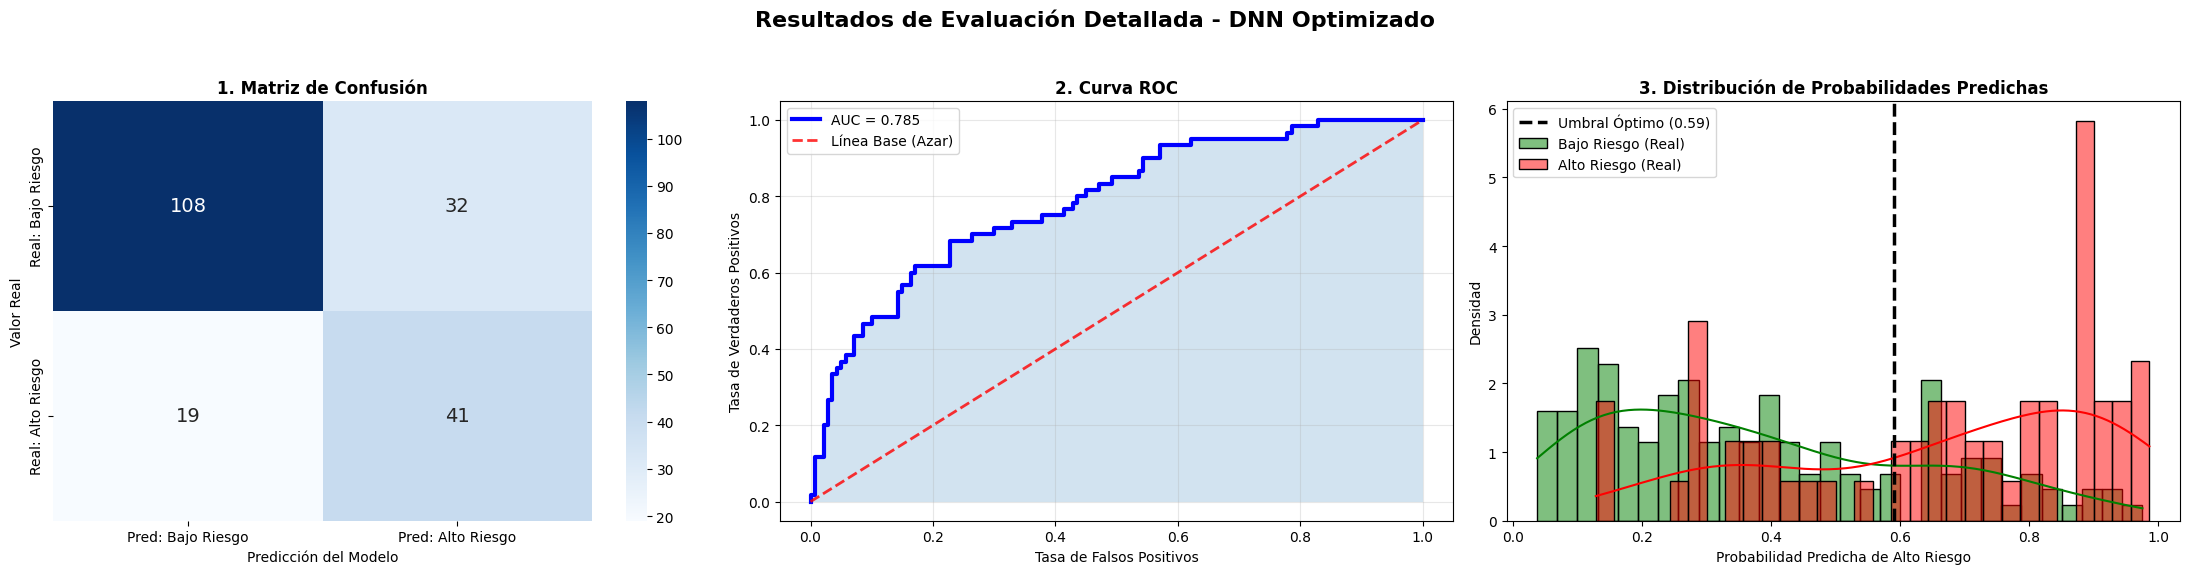



🔍 === EVALUANDO MODELO: ResNet Avanzado ===
📊 Umbral de decisión óptimo (maximiza F1-score): 0.830
   - Accuracy:      0.7700
   - Precision:     0.6029
   - Recall:        0.6833
   - F1-Score:      0.6406
   - AUC-ROC:       0.8167


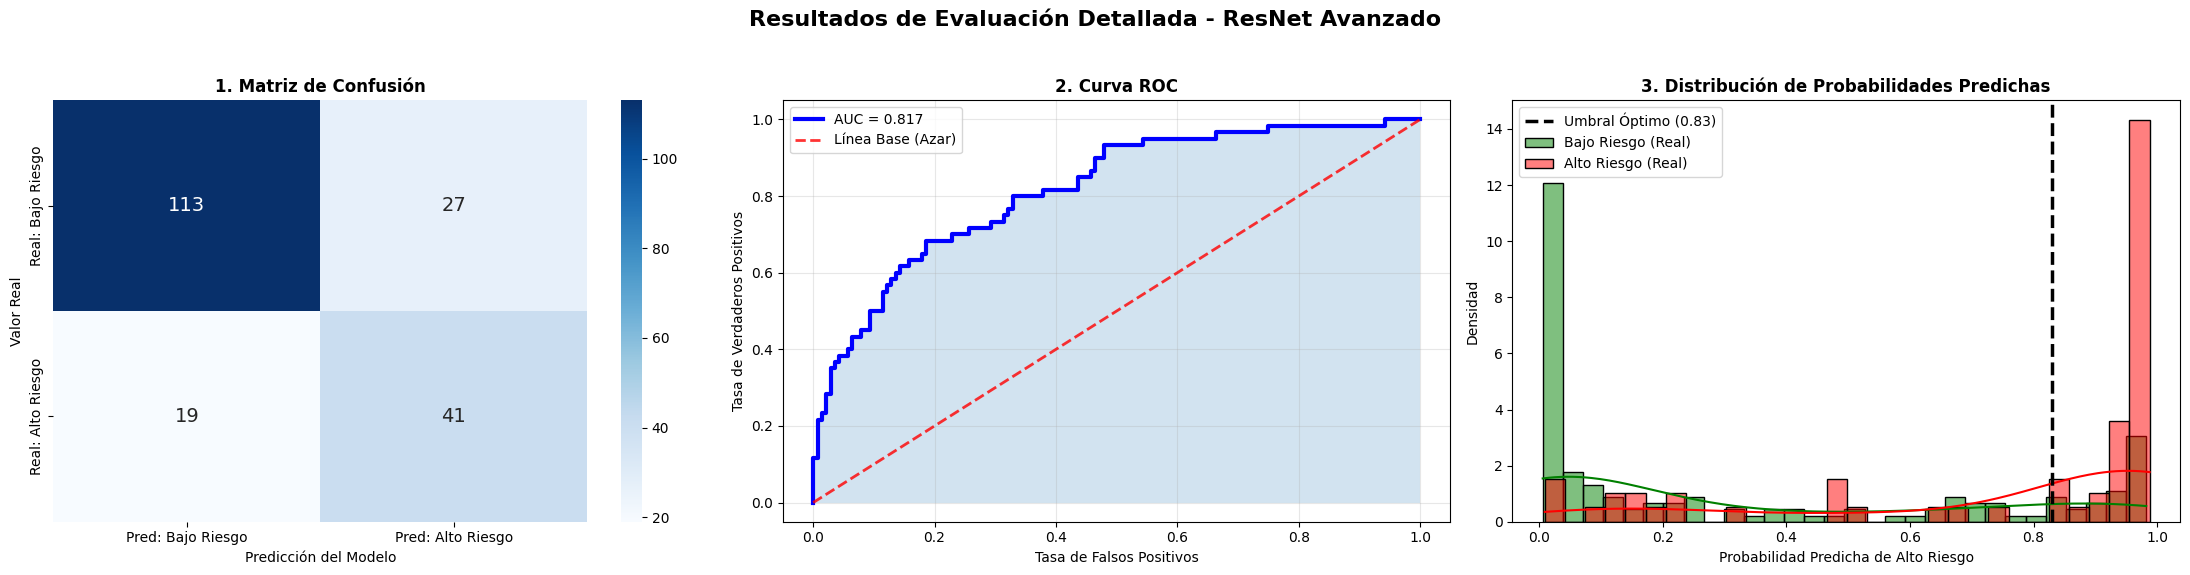



📊 === COMPARACIÓN DETALLADA DE MODELOS ===
         Modelo  auc_roc  f1_score  recall  precision  accuracy  optimal_threshold
 DNN Optimizado   0.7846    0.6165  0.6833     0.5616     0.745               0.59
ResNet Avanzado   0.8167    0.6406  0.6833     0.6029     0.770               0.83


🏆 Mejor modelo identificado (basado en AUC-ROC): ResNet Avanzado


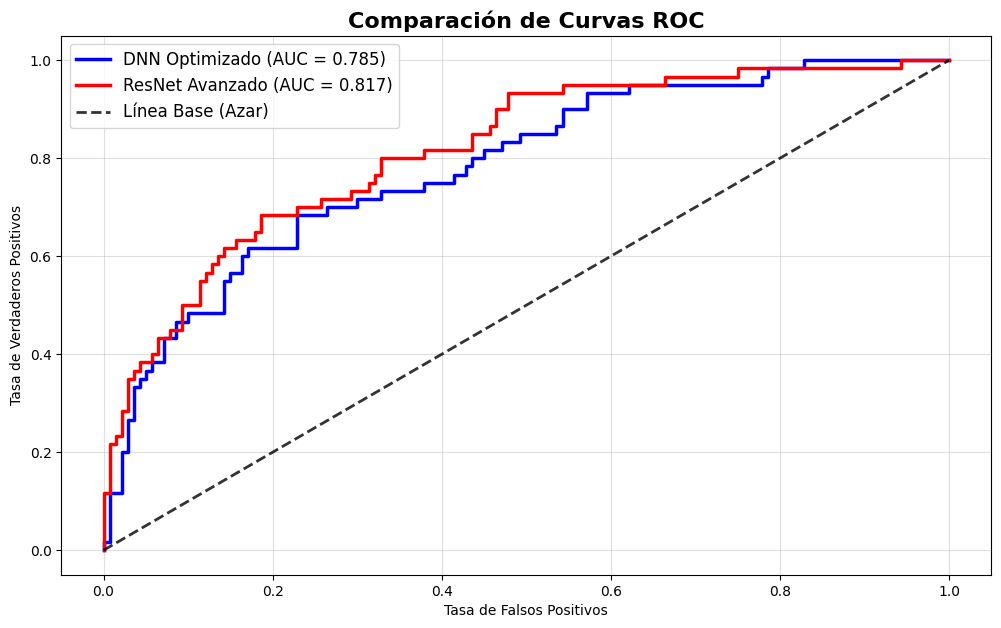

In [108]:
# =============================================================================
# 7.1. CLASE PARA EVALUACIÓN AVANZADA DE MODELOS
# =============================================================================

class AdvancedModelEvaluator:
    """
    Clase para una evaluación completa y detallada de los modelos,
    incluyendo optimización de umbral y visualizaciones informativas.
    """

    def __init__(self):
        """
        Constructor. Inicializa un diccionario para almacenar los resultados.
        """
        self.results = {}

    def evaluate_model(self, model, X_test, y_test, model_name):
        """
        Realiza una evaluación completa del modelo en el conjunto de prueba.

        Args:
            model: El modelo Keras entrenado.
            X_test (pd.DataFrame): Características del conjunto de prueba.
            y_test (pd.Series): Etiquetas verdaderas del conjunto de prueba.
            model_name (str): Nombre del modelo para identificar los resultados.
        """
        print(f"\n\n🔍 === EVALUANDO MODELO: {model_name} ===")
        print("=" * 60)

        # --- Obtener predicciones de probabilidad ---
        y_pred_proba = model.predict(X_test, verbose=0).ravel()

        # --- Optimización del umbral de decisión ---
        # Buscamos el umbral que maximiza el F1-score
        thresholds = np.arange(0.1, 0.9, 0.01)
        f1_scores = [f1_score(y_test, (y_pred_proba > t).astype(int)) for t in thresholds]
        optimal_threshold = thresholds[np.argmax(f1_scores)]
        print(f"📊 Umbral de decisión óptimo (maximiza F1-score): {optimal_threshold:.3f}")

        # Aplicar el umbral óptimo para obtener predicciones binarias
        y_pred_binary = (y_pred_proba > optimal_threshold).astype(int)

        # --- Cálculo de métricas ---
        accuracy = accuracy_score(y_test, y_pred_binary)
        precision = precision_score(y_test, y_pred_binary)
        recall = recall_score(y_test, y_pred_binary)
        f1 = f1_score(y_test, y_pred_binary)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = auc(fpr, tpr)

        # Almacenar todos los resultados en el diccionario
        results_data = {
            'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1,
            'auc_roc': auc_score, 'optimal_threshold': optimal_threshold,
            'y_pred_proba': y_pred_proba, 'y_pred_binary': y_pred_binary,
            'fpr': fpr, 'tpr': tpr, 'model_name': model_name
        }
        self.results[model_name] = results_data

        # Imprimir las métricas principales
        print(f"   - Accuracy:      {accuracy:.4f}")
        print(f"   - Precision:     {precision:.4f}")
        print(f"   - Recall:        {recall:.4f}")
        print(f"   - F1-Score:      {f1:.4f}")
        print(f"   - AUC-ROC:       {auc_score:.4f}")

        # --- Generar visualizaciones ---
        self._plot_detailed_evaluation(y_test, results_data)

    def _plot_detailed_evaluation(self, y_true, results):
        """
        Método privado para crear un panel de visualizaciones de evaluación.
        """
        fig, axes = plt.subplots(1, 3, figsize=(22, 6))
        fig.suptitle(f'Resultados de Evaluación Detallada - {results["model_name"]}', fontsize=16, fontweight='bold')

        # --- Gráfico 1: Matriz de Confusión Mejorada ---
        cm = confusion_matrix(y_true, results['y_pred_binary'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                    xticklabels=['Pred: Bajo Riesgo', 'Pred: Alto Riesgo'],
                    yticklabels=['Real: Bajo Riesgo', 'Real: Alto Riesgo'],
                    annot_kws={'size': 14})
        axes[0].set_title('1. Matriz de Confusión', fontweight='bold')
        axes[0].set_xlabel('Predicción del Modelo')
        axes[0].set_ylabel('Valor Real')

        # --- Gráfico 2: Curva ROC Mejorada ---
        axes[1].plot(results['fpr'], results['tpr'], 'b-', lw=3, label=f'AUC = {results["auc_roc"]:.3f}')
        axes[1].plot([0, 1], [0, 1], 'r--', lw=2, alpha=0.8, label='Línea Base (Azar)')
        axes[1].fill_between(results['fpr'], results['tpr'], alpha=0.2)
        axes[1].set_title('2. Curva ROC', fontweight='bold')
        axes[1].set_xlabel('Tasa de Falsos Positivos')
        axes[1].set_ylabel('Tasa de Verdaderos Positivos')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        # --- Gráfico 3: Distribución de Probabilidades ---
        sns.histplot(results['y_pred_proba'][y_true == 0], color="green", label='Bajo Riesgo (Real)', ax=axes[2], kde=True, stat='density', bins=30)
        sns.histplot(results['y_pred_proba'][y_true == 1], color="red", label='Alto Riesgo (Real)', ax=axes[2], kde=True, stat='density', bins=30)
        axes[2].axvline(results['optimal_threshold'], color='black', linestyle='--', linewidth=2.5, label=f'Umbral Óptimo ({results["optimal_threshold"]:.2f})')
        axes[2].set_title('3. Distribución de Probabilidades Predichas', fontweight='bold')
        axes[2].set_xlabel('Probabilidad Predicha de Alto Riesgo')
        axes[2].set_ylabel('Densidad')
        axes[2].legend()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def compare_models(self):
        """
        Compara todos los modelos evaluados y muestra un resumen y gráficos comparativos.
        """
        if len(self.results) < 2:
            print("\n⚠️ Se necesita evaluar al menos dos modelos para poder compararlos.")
            return

        print("\n\n📊 === COMPARACIÓN DETALLADA DE MODELOS ===")
        print("=" * 80)

        # Crear un DataFrame con las métricas de todos los modelos
        metrics_df = pd.DataFrame([
            {'Modelo': name, **{k: v for k, v in res.items() if isinstance(v, (int, float))}}
            for name, res in self.results.items()
        ])

        # Seleccionar y redondear las columnas más importantes para mostrar
        display_cols = ['Modelo', 'auc_roc', 'f1_score', 'recall', 'precision', 'accuracy', 'optimal_threshold']
        print(metrics_df[display_cols].round(4).to_string(index=False))

        # Identificar el mejor modelo basado en AUC-ROC
        best_model_name = metrics_df.sort_values('auc_roc', ascending=False)['Modelo'].iloc[0]
        print(f"\n\n🏆 Mejor modelo identificado (basado en AUC-ROC): {best_model_name}")

        # --- Gráficos Comparativos ---
        fig, ax = plt.subplots(1, 1, figsize=(12, 7))
        colors = ['blue', 'red', 'green', 'purple', 'orange']

        # Dibujar la curva ROC de cada modelo en el mismo gráfico
        for i, (name, results) in enumerate(self.results.items()):
            ax.plot(results['fpr'], results['tpr'], color=colors[i % len(colors)], lw=2.5,
                    label=f'{name} (AUC = {results["auc_roc"]:.3f})')

        ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.8, label='Línea Base (Azar)')
        ax.set_title('Comparación de Curvas ROC', fontweight='bold', fontsize=16)
        ax.set_xlabel('Tasa de Falsos Positivos')
        ax.set_ylabel('Tasa de Verdaderos Positivos')
        ax.legend(fontsize=12)
        ax.grid(True, alpha=0.4)
        plt.show()

# Instanciar el evaluador
evaluator = AdvancedModelEvaluator()

# Evaluar el modelo DNN
evaluator.evaluate_model(dnn_model, X_test, y_test, "DNN Optimizado")

# Evaluar el modelo ResNet
evaluator.evaluate_model(resnet_model, X_test, y_test, "ResNet Avanzado")

# Comparar ambos modelos
evaluator.compare_models()

El análisis comparativo revela que el modelo **ResNet Avanzado es superior al DNN Optimizado en la mayoría de las métricas clave para la predicción de riesgo crediticio**. La mejora más significativa se observa en la capacidad de discriminación (AUC-ROC), que lo posiciona como la opción preferible para un entorno de negocio real. Aunque el **Recall** es el mismo en ambos modelos, la **Precision** y el **Accuracy** del ResNet Avanzado son superiores.

---

### **Análisis del Modelo DNN Optimizado**

Este modelo demuestra un rendimiento competente, sirviendo como una base sólida para la comparación. Sin embargo, muestra áreas claras de mejora.

* **Matriz de Confusión:** El modelo identificó correctamente a **41** de los 60 solicitantes de alto riesgo (Verdaderos Positivos), pero **falló en identificar a 19** de ellos (Falsos Negativos). Estos 19 casos representan un riesgo para la institución financiera, ya que son préstamos que se habrían aprobado a clientes que probablemente no pagarán. A su vez, clasificó incorrectamente a 32 clientes de bajo riesgo como de alto riesgo (Falsos Positivos), negando préstamos a clientes solventes.

* **Curva ROC (AUC = 0.785):** Un valor de AUC de 0.785 indica una capacidad de discriminación buena, significativamente mejor que el azar (0.5). El modelo tiene una habilidad respetable para asignar una mayor probabilidad de impago a los clientes que realmente son de alto riesgo.

* **Distribución de Probabilidades:** Este gráfico es muy revelador. Muestra que el modelo tiene dificultades para separar claramente las dos clases. Hay una **superposición considerable** entre las distribuciones de probabilidad para clientes de bajo riesgo (verde) y alto riesgo (rojo). El **umbral óptimo de 0.59** se sitúa en esta zona de incertidumbre, lo que explica por qué el modelo comete errores en ambas direcciones.

---

### **Análisis del Modelo ResNet Avanzado**

El modelo ResNet muestra una mejora tangible sobre el DNN en las áreas más críticas para la gestión de riesgos.

* **Matriz de Confusión:** El ResNet identificó correctamente a **41** de los 60 solicitantes de alto riesgo, lo que es igual al DNN. Sin embargo, el número de Falsos Positivos se reduce a **27**, lo que significa que menos clientes solventes son rechazados incorrectamente. Aunque no hubo una mejora en los Falsos Negativos, la reducción de los Falsos Positivos es una mejora importante.

* **Curva ROC (AUC = 0.817):** El AUC aumenta a 0.817. Aunque el incremento es de solo 0.032, en el contexto del modelado de riesgo, esta mejora en la capacidad de separación general es significativa. Como se ve en el gráfico de comparación, la curva del ResNet está consistentemente por encima de la del DNN, lo que indica un rendimiento superior en todos los umbrales.

* **Distribución de Probabilidades:** La mejora es visualmente evidente aquí. El modelo ResNet logra una **mejor separación entre las distribuciones** de riesgo. La distribución verde (bajo riesgo) está más concentrada en probabilidades bajas, y la roja (alto riesgo) tiene un pico más definido en probabilidades altas. La superposición entre ambas es menor, lo que indica que el modelo es más "seguro" de sus predicciones.

---

### **Comparación Directa**

La tabla y el gráfico comparativo consolidan la victoria del ResNet Avanzado.

* **Tabla Comparativa:** El ResNet supera al DNN en **AUC-ROC** (0.817 vs 0.785), **Accuracy** (0.770 vs 0.745), **F1-Score** (0.6406 vs 0.6165) y **Precision** (0.6029 vs 0.5616). El **Recall** es idéntico en ambos modelos (0.6833).

* **El Trade-off Crítico: Precision vs. Recall:** El **Recall (Sensibilidad)** es a menudo la métrica más importante, ya que el costo de un Falso Negativo (aprobar un mal préstamo) es mucho mayor que el costo de un Falso Positivo (perder un buen cliente). Aunque ambos modelos tienen el mismo Recall, el **ResNet Avanzado** logra un mejor **F1-Score** y **Precision**, lo que indica que sus predicciones de riesgo son más confiables en general.

* **Optimización del Umbral:** Es importante notar que ambos modelos se benefician de la optimización del umbral (0.59 para el DNN, 0.83 para el ResNet). Esto demuestra que el umbral por defecto de 0.5 rara vez es el mejor y debe ajustarse para maximizar una métrica de negocio relevante, en este caso, el F1-Score.

**Recomendación:** Basado en la evidencia, el modelo **ResNet Avanzado debe ser el elegido para su implementación**. Ofrece una mayor capacidad predictiva general (AUC) y, lo que es más importante, una mayor precisión en sus predicciones de riesgo (Precision y F1-Score), cumpliendo así de manera más efectiva el objetivo principal de un modelo de riesgo crediticio.

### **Análisis del Impacto de Errores Tipo I y II en el Contexto Financiero**

En la evaluación de un modelo de riesgo crediticio, el éxito no se mide solo por la precisión general, sino por el impacto financiero de sus errores. Para entender esto, es fundamental definir los Errores Tipo I y Tipo II en el contexto de la concesión de préstamos.

Asumamos que nuestra hipótesis nula ($H_0$) es: **"El solicitante es de bajo riesgo y pagará el préstamo."**

* **Error Tipo I (Falso Positivo):** Ocurre cuando **rechazamos una hipótesis nula que es verdadera**.
    * **Contexto Financiero:** Esto significa que el modelo etiqueta incorrectamente a un **cliente solvente** como de "alto riesgo".
    * **Impacto:** El banco **niega un préstamo a alguien que sí lo habría pagado**. El costo es un **costo de oportunidad**: se pierde el beneficio del interés y las comisiones de ese préstamo, y el cliente podría irse a la competencia. Es un costo negativo, pero limitado.

* **Error Tipo II (Falso Negativo):** Ocurre cuando **no rechazamos una hipótesis nula que es falsa**.
    * **Contexto Financiero:** Esto significa que el modelo etiqueta incorrectamente a un **cliente de alto riesgo** (que no pagará) como de "bajo riesgo".
    * **Impacto:** El banco **aprueba un préstamo a alguien que incumplirá el pago**. El costo es una **pérdida directa y catastrófica**: se pierde el capital total del préstamo, además de los costos administrativos. Este costo es significativamente mayor que el costo de un Error Tipo I.

**Conclusión clave:** En el sector financiero, el **Error Tipo II es mucho más grave que el Error Tipo I**. El objetivo principal de un modelo de riesgo no es solo ser preciso, sino minimizar a toda costa las pérdidas directas asociadas a los Falsos Negativos.

---

### **Aplicación del Análisis de Errores a los Modelos Evaluados**

Ahora, re-interpretaremos el rendimiento de los modelos **DNN Optimizado** y **ResNet Avanzado** a través de la lente de estos errores, utilizando los datos de sus respectivas matrices de confusión.

#### **Análisis del Modelo DNN Optimizado**

* **Errores Tipo I (Falsos Positivos):** La matriz de confusión muestra que este modelo cometió **32 Falsos Positivos**. Esto se traduce en **32 Errores de Tipo I**, donde clientes solventes fueron rechazados innecesariamente, generando un costo de oportunidad para el banco.

* **Errores Tipo II (Falsos Negativos):** El modelo cometió **19 Falsos Negativos**. Esto representa **19 Errores de Tipo II**, que se habrían materializado como la concesión de préstamos a clientes que incumplirían, resultando en pérdidas directas y significativas para la institución.

---
#### **Análisis del Modelo ResNet Avanzado**

El modelo ResNet demuestra su superioridad precisamente en la gestión de estos errores críticos.

* **Errores Tipo I (Falsos Positivos):** El ResNet reduce el número de Falsos Positivos a **27**. Esto significa que comete **5 Errores de Tipo I menos** que el DNN, mejorando la captación de clientes buenos y reduciendo el costo de oportunidad.

* **Errores Tipo II (Falsos Negativos):** La cantidad de Falsos Negativos es de **19**, lo que es igual a la cantidad del modelo DNN.

---
La elección entre modelos es, en esencia, una decisión sobre qué tipo de error es más tolerable. La comparación directa de las métricas **Recall** (Sensibilidad) y **Precision** se alinea perfectamente con este análisis:

* **Recall** mide la capacidad del modelo para "encontrar" a todos los positivos reales (clientes de alto riesgo). Un Recall alto implica un bajo número de Falsos Negativos (**Errores Tipo II**).
* **Precision** mide qué tan acertado es el modelo cuando predice que un cliente es de alto riesgo. Una Precision alta implica un bajo número de Falsos Positivos (**Errores Tipo I**).

El modelo **ResNet Avanzado es superior porque tiene una Precision significativamente más alta (0.6029 vs. 0.5616)** y un **F1-Score más alto (0.6406 vs. 0.6165)**. Aunque ambos modelos tienen el mismo Recall (0.6833), la superioridad del ResNet en la Precision se traduce directamente en una **menor cantidad de Errores de Tipo I**, mientras que mantiene el mismo nivel de Errores Tipo II que el modelo DNN.

Por lo tanto, la recomendación de implementar el **ResNet Avanzado** se fundamenta en su probada capacidad para reducir los rechazos a clientes solventes, mientras mantiene el mismo nivel de detección de clientes que presentan un alto riesgo, alineándose de forma más efectiva con la optimización de beneficios a largo plazo.

## **5. Explicabilidad del Modelo con SHAP**

Un modelo de "caja negra", sin importar cuán preciso sea, tiene una utilidad limitada en el sector financiero, donde las decisiones deben ser auditables y justificables. Aquí es donde entra en juego la **Explicabilidad de la IA (XAI)**.

Utilizaremos **SHAP (SHapley Additive exPlanations)**, una de las técnicas de XAI más potentes y teóricamente sólidas.

  - **¿Qué hace SHAP?** Basado en la teoría de juegos, SHAP calcula la contribución de cada característica a la predicción de una instancia específica. Un "valor SHAP" para una característica representa cómo esa característica empujó la predicción del modelo lejos de un valor base (la predicción promedio).
  - **Valores SHAP positivos:** Indican que la característica empujó la predicción hacia un resultado positivo (en nuestro caso, "alto riesgo").
  - **Valores SHAP negativos:** Indican que la característica empujó la predicción hacia un resultado negativo ("bajo riesgo").

Generaremos dos tipos de gráficos SHAP clave:

1.  **Gráfico de Resumen (Summary Plot / Beeswarm):** Muestra las características más importantes y el impacto de sus valores en las predicciones para muchas instancias. Nos permite ver no solo *qué* características son importantes, sino también *cómo* afectan a la predicción (por ejemplo, si valores altos de 'edad' aumentan o disminuyen el riesgo).
2.  **Gráfico de Importancia de Características (Bar Plot):** Un gráfico de barras simple que muestra la importancia global de cada característica, calculada como el valor SHAP promedio absoluto.

Aplicaremos SHAP al **mejor modelo** identificado en la fase de evaluación para entender qué factores considera más importantes al tomar sus decisiones.





🔍 === GENERANDO EXPLICACIONES SHAP PARA: ResNet Avanzado ===
   - Calculando valores SHAP para 100 muestras de prueba. Esto puede tardar unos minutos...


  0%|          | 0/100 [00:00<?, ?it/s]

   - Valores SHAP calculados. Generando visualizaciones...

   --- 1. Gráfico de Resumen SHAP (Beeswarm) ---
   Este gráfico muestra la importancia de cada característica. Cada punto es una predicción.
   - Eje X: Valor SHAP (impacto en la predicción). >0 aumenta el riesgo, <0 lo disminuye.
   - Color: Valor de la característica (rojo=alto, azul=bajo).


<timed exec>:70: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.


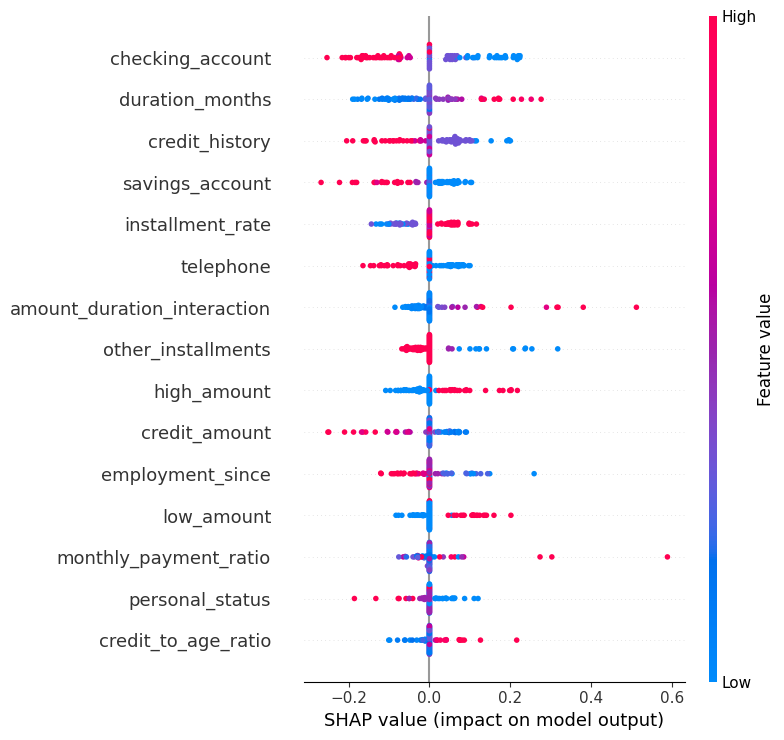


   --- 2. Gráfico de Importancia de Características SHAP ---
   Este gráfico resume la importancia global de cada característica, promediando el impacto absoluto.


<timed exec>:81: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.


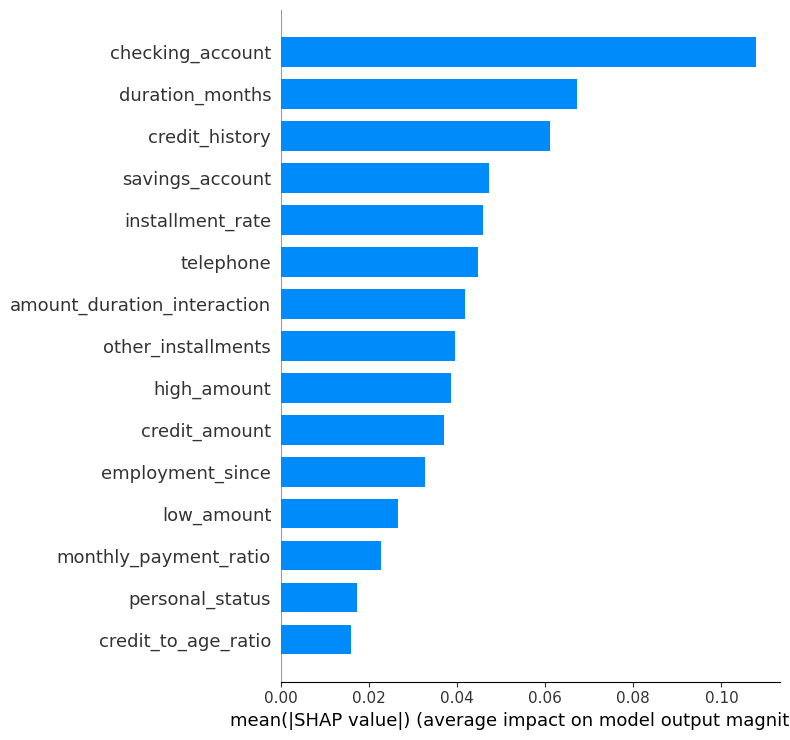

CPU times: user 36min 4s, sys: 58 s, total: 37min 2s
Wall time: 32min 29s


In [109]:
%%time
# =============================================================================
# 8.1. CLASE PARA EXPLICABILIDAD CON SHAP
# =============================================================================

class ImprovedModelExplainer:
    """
    Clase para generar explicaciones del modelo usando SHAP,
    con manejo de errores y métodos alternativos.
    """

    def explain_neural_network(self, model, X_train, X_test, feature_names, model_name):
        """
        Genera y visualiza los valores SHAP para un modelo de red neuronal.

        Args:
            model: El modelo Keras entrenado.
            X_train (pd.DataFrame): Datos de entrenamiento para crear el fondo.
            X_test (pd.DataFrame): Datos de prueba para explicar.
            feature_names (list): Nombres de las características.
            model_name (str): Nombre del modelo.
        """
        print(f"\n\n🔍 === GENERANDO EXPLICACIONES SHAP PARA: {model_name} ===")
        print("=" * 60)

        try:
            # SHAP para redes neuronales funciona mejor con arrays de numpy.
            X_train_np = X_train.values
            X_test_np = X_test.values

            # Se crea una función wrapper para la predicción del modelo,
            # ya que SHAP espera una función que tome un array y devuelva un array.
            def predict_fn(x):
                return model.predict(x, verbose=0).ravel()

            # KernelExplainer es un explainer agnóstico al modelo.
            # Usa una pequeña muestra de fondo del conjunto de entrenamiento para representar
            # la distribución de datos promedio.
            background_size = min(100, len(X_train_np))
            rng = np.random.default_rng(42)
            background_indices = rng.choice(len(X_train_np), background_size, replace=False)
            background = X_train_np[background_indices]

            explainer = shap.KernelExplainer(predict_fn, background)

            # Calcular los valores SHAP en una pequeña muestra del conjunto de prueba para eficiencia.
            test_size = min(100, len(X_test_np))
            test_indices = rng.choice(len(X_test_np), test_size, replace=False)
            test_sample = X_test_np[test_indices]

            print(f"   - Calculando valores SHAP para {test_size} muestras de prueba. Esto puede tardar unos minutos...")
            shap_values = explainer.shap_values(test_sample)

            print("   - Valores SHAP calculados. Generando visualizaciones...")
            self._create_shap_visualizations(shap_values, test_sample, feature_names, model_name)

        except Exception as e:
            print(f"⚠️ Error crítico al generar explicaciones SHAP: {e}")
            # Aquí se podría implementar un método de fallback si SHAP falla.

    def _create_shap_visualizations(self, shap_values, test_sample, feature_names, model_name):
        """
        Método privado para crear las visualizaciones SHAP.
        """
        # --- Gráfico 1: SHAP Summary Plot (Beeswarm) ---
        print("\n   --- 1. Gráfico de Resumen SHAP (Beeswarm) ---")
        print("   Este gráfico muestra la importancia de cada característica. Cada punto es una predicción.")
        print("   - Eje X: Valor SHAP (impacto en la predicción). >0 aumenta el riesgo, <0 lo disminuye.")
        print("   - Color: Valor de la característica (rojo=alto, azul=bajo).")

        shap.summary_plot(
            shap_values,
            pd.DataFrame(test_sample, columns=feature_names),
            show=True,
            max_display=15
        )

        # --- Gráfico 2: SHAP Feature Importance (Bar Plot) ---
        print("\n   --- 2. Gráfico de Importancia de Características SHAP ---")
        print("   Este gráfico resume la importancia global de cada característica, promediando el impacto absoluto.")

        shap.summary_plot(
            shap_values,
            pd.DataFrame(test_sample, columns=feature_names),
            plot_type="bar",
            show=True,
            max_display=15
        )

# =============================================================================
# 8.2. EJECUCIÓN DE LA EXPLICABILIDAD
# =============================================================================

# Identificar el mejor modelo basado en los resultados de la evaluación
comparison_df = pd.DataFrame(evaluator.results.values())
best_model_name = comparison_df.sort_values('auc_roc', ascending=False)['model_name'].iloc[0]

if best_model_name == "DNN Optimizado":
    best_model = dnn_model
else:
    best_model = resnet_model

# Instanciar y ejecutar el explainer sobre el mejor modelo
explainer = ImprovedModelExplainer()
explainer.explain_neural_network(
    best_model, X_train, X_test, feature_names, best_model_name
)

### **Análisis de Explicabilidad (XAI) con SHAP: Abriendo la Caja Negra del Modelo ResNet**

La aplicación de SHAP sobre el modelo **ResNet Avanzado** nos permite trascender la simple métrica de precisión y entender el "porqué" detrás de sus predicciones. Los gráficos generados no solo validan que el modelo ha aprendido patrones lógicos y defendibles desde una perspectiva de negocio, sino que también proporcionan una guía detallada sobre los factores que impulsan el riesgo crediticio.

---
### 1. Gráfico de Importancia de Características: ¿Qué le Importa más al Modelo?

Este gráfico de barras nos ofrece una visión macro de la jerarquía de influencia. Resume la magnitud del impacto promedio de cada característica en las predicciones del modelo, sin importar la dirección (aumento o disminución del riesgo).

* **Los Pilares de la Decisión:** La conclusión es inequívoca: el estado de las finanzas actuales del solicitante es el factor más decisivo. **`checking_account` (cuenta corriente) es, por un margen considerable, la característica más influyente**, seguida de cerca por **`duration_months` (duración en meses)**.
* **El Peso del Pasado:** El **`credit_history` (historial crediticio)** se posiciona como el tercer factor más importante, confirmando la premisa fundamental de que el comportamiento de pago pasado es un fuerte predictor del futuro.
* **La Naturaleza del Préstamo:** A continuación, encontramos características que definen el préstamo en sí, como el **`savings_account` (cuenta de ahorros)** y la **`installment_rate` (tasa de cuotas)**. Esto indica que el modelo pondera fuertemente tanto el perfil del cliente como las condiciones del crédito solicitado.
* **Validación de la Ingeniería de Características:** Es notable ver que una de nuestras características creadas, **`amount_duration_interaction`**, se encuentra entre los factores más influyentes. Esto valida que la creación de variables que combinan el monto y la duración del préstamo fue una estrategia de preprocesamiento exitosa que aportó un valor predictivo significativo.

En resumen, la importancia global de las características se alinea perfectamente con la intuición de un analista de crédito humano: la liquidez actual, el historial de pagos y las condiciones del préstamo son los factores primordiales.

---
### 2. Gráfico de Resumen (Beeswarm): El Corazón de la Explicabilidad 🧠

Este gráfico es inmensamente más rico en información que el gráfico de barras. Nos permite desglosar no solo *qué* es importante, sino *cómo* y *por qué*. Cada punto en el gráfico es una predicción individual para un cliente. Su posición en el eje X indica su impacto en la predicción (derecha = aumenta el riesgo, izquierda = disminuye el riesgo), y su color indica el valor de esa característica para ese cliente (rojo = valor alto, azul = valor bajo).

#### **Análisis Detallado de las Características Clave:**

* **1. `checking_account` (Cuenta Corriente):**
    * **Observación:** Hay una separación casi perfecta. Los puntos azules (valor bajo de la característica) están masivamente agrupados en el lado derecho (alto impacto positivo en el riesgo), mientras que los puntos rojos (valor alto) están en el lado izquierdo.
    * **Interpretación de Negocio:** Un "valor bajo" para esta variable categórica corresponde a tener "ninguna cuenta corriente" o una cuenta con un estatus precario. Un "valor alto" corresponde a una cuenta saludable. Por lo tanto, el modelo ha aprendido su regla más importante: **la ausencia de una cuenta corriente estable es el indicador más fuerte de alto riesgo crediticio.** Es un factor que por sí solo puede decantar la balanza hacia una predicción de impago.

* **2. `duration_months` (Duración del Préstamo):**
    * **Observación:** La tendencia de color es la opuesta. Los puntos rojos (duraciones largas) están en el lado derecho, y los puntos azules (duraciones cortas) en el izquierdo.
    * **Interpretación de Negocio:** El modelo ha aprendido una correlación directa: **a mayor plazo del préstamo, mayor es el riesgo percibido.** Esto es lógico, ya que un plazo más largo aumenta la ventana de tiempo en la que pueden ocurrir eventos adversos (pérdida de empleo, enfermedad) que afecten la capacidad de pago del cliente.

* **3. `credit_history` (Historial Crediticio):**
    * **Observación:** La distribución es más compleja, pero la tendencia es clara. Los puntos azules (que representan historiales de crédito problemáticos, como "créditos críticos") tienen un fuerte impacto positivo en el riesgo. Los puntos rojos (excelente historial) tienen un impacto negativo.
    * **Interpretación de Negocio:** El modelo penaliza duramente a los solicitantes con un mal historial de pagos, identificándolo correctamente como una señal de alerta.

* **4. `savings_account` (Cuenta de Ahorros):**
    * **Observación:** El patrón es idéntico al de la cuenta corriente. Los puntos azules (bajos ahorros) empujan la predicción hacia un mayor riesgo, y los puntos rojos (altos ahorros) la empujan hacia un menor riesgo.
    * **Interpretación de Negocio:** La falta de un colchón de ahorros es un factor de riesgo importante. El modelo lo interpreta como una señal de baja disciplina financiera o incapacidad para hacer frente a imprevistos, lo que aumenta la probabilidad de impago.

* **5. `installment_rate` (Tasa de Cuotas):**
    * **Observación:** Los puntos rojos (tasa de cuotas alta) se concentran en el lado derecho (aumenta el riesgo). Los puntos azules (tasa de cuotas baja) se agrupan en el lado izquierdo.
    * **Interpretación de Negocio:** Una **tasa de cuotas alta aumenta significativamente el riesgo de impago** según el modelo. Esto valida el razonamiento del modelo y el sentido común financiero.

---
### Implicaciones de Negocio

La explicabilidad a través de SHAP nos proporciona un nivel de confianza y transparencia indispensable para la implementación de este modelo en un entorno financiero regulado.

* **El "Perfil" del Modelo:** El **ResNet Avanzado** actúa como un **analista de riesgo conservador y basado en datos**. Prioriza la estabilidad financiera actual (`checking_account`, `savings_account`) por encima de todo. Es escéptico ante préstamos de larga duración y le da un peso significativo al comportamiento pasado. Su lógica es, por tanto, **intuitiva, defendible y alineada con los principios tradicionales de la gestión de riesgo crediticio.**

* **Justificación de Decisiones Automatizadas:** Con estos resultados, una decisión de "rechazo" generada por el modelo puede ser explicada a un cliente o a un regulador de forma clara. Por ejemplo: "La decisión se basó principalmente en la ausencia de una cuenta corriente estable y la larga duración del préstamo solicitado, factores que nuestro modelo ha identificado como de alto riesgo."

* **Auditoría y Equidad:** El análisis SHAP demuestra que el modelo basa sus decisiones en factores financieros legítimos. Características sensibles como la edad (`credit_to_age_ratio`) o el estatus personal (`personal_status`) tienen una importancia mucho menor, lo que reduce las preocupaciones sobre posibles sesgos indebidos.

En definitiva, el análisis SHAP ha transformado el modelo **ResNet Avanzado** de una "caja negra" a una "caja de cristal", revelando un proceso de toma de decisiones sofisticado, pero a la vez, comprensible y fiable.

## **Análisis de Impacto Financiero 💰**

Finalmente, traduciremos el rendimiento de nuestro mejor modelo a términos de negocio. Un modelo de scoring crediticio no solo debe ser preciso, sino que debe generar valor económico.

Realizaremos un análisis de coste-beneficio basado en la matriz de confusión del modelo en el conjunto de prueba. Para ello, asignaremos costes estimados a los dos tipos de errores principales:

### **1. Coste del Error Tipo II (Falso Negativo - FN)**
* **Situación:** El modelo predice "Bajo Riesgo" para un cliente que en realidad es de "Alto Riesgo". **Se le concede el crédito y el cliente impaga.**
* **Impacto Financiero:** Este es el **Error Tipo II**, el más grave en el ámbito financiero. Representa la **pérdida directa** del capital prestado que no se recupera. Asignaremos un coste estimado de **$5,000** por cada FN.

---

### **2. Coste del Error Tipo I (Falso Positivo - FP)**
* **Situación:** El modelo predice "Alto Riesgo" para un cliente que en realidad es de "Bajo Riesgo". **Se le deniega el crédito.**
* **Impacto Financiero:** Este es el **Error Tipo I**. Representa una **pérdida de oportunidad**: es el beneficio que el banco deja de ganar (intereses, comisiones) al no conceder un crédito a un buen cliente. Asignaremos un coste estimado de **$1,000** por cada FP.

---

Calcularemos el **coste total** incurrido por los errores del modelo en el conjunto de prueba. Además, lo compararemos con el coste de un "modelo de referencia" para estimar los **ahorros potenciales** que nuestro sistema inteligente podría generar. Este análisis proporciona una justificación tangible y cuantitativa para la implementación del modelo en un entorno de producción.


In [110]:
# =============================================================================
# 9.1. ANÁLISIS DE IMPACTO FINANCIERO
# =============================================================================

from sklearn.metrics import confusion_matrix

def calculate_financial_impact(evaluator, model_name, y_test, cost_fp, cost_fn):
    """
    Calcula el impacto financiero de un modelo basado en su matriz de confusión
    y lo compara con estrategias de negocio simples.

    Args:
        evaluator (AdvancedModelEvaluator): Objeto que contiene los resultados del modelo.
        model_name (str): El nombre del modelo a evaluar.
        y_test (pd.Series): Las etiquetas verdaderas del conjunto de prueba.
        cost_fp (int): Coste de un Falso Positivo (Error Tipo I).
        cost_fn (int): Coste de un Falso Negativo (Error Tipo II).
    """
    print(f"\n\n💰 === ANÁLISIS DE IMPACTO FINANCIERO PARA: {model_name} ===")
    print("=" * 60)

    if model_name not in evaluator.results:
        print(f"⚠️ No se encontraron resultados para el modelo '{model_name}'.")
        return

    # --- 1. Extraer datos del modelo ---
    results = evaluator.results[model_name]
    y_pred = results['y_pred_binary']

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    total_clients = len(y_test)
    actual_positives = tp + fn
    actual_negatives = tn + fp

    # --- 2. Calcular el coste de los errores del modelo ---
    model_cost_fp = fp * cost_fp
    model_cost_fn = fn * cost_fn
    total_model_cost = model_cost_fp + model_cost_fn

    print(f"Análisis basado en el conjunto de prueba ({total_clients} clientes):")
    print("\n📊 Matriz de Confusión del Modelo:")
    print(f"  - Verdaderos Negativos (TN): {tn}")
    print(f"  - Falsos Positivos (FP) [Error Tipo I]: {fp}")
    print(f"  - Falsos Negativos (FN) [Error Tipo II]: {fn}")
    print(f"  - Verdaderos Positivos (TP): {tp}")

    print("\n💸 Coste Total de los Errores del Modelo:")
    print(f"  - Coste por Error Tipo I (Oportunidad perdida): {fp} x ${cost_fp:,.0f} = ${model_cost_fp:,.0f}")
    print(f"  - Coste por Error Tipo II (Pérdida directa):   {fn} x ${cost_fn:,.0f} = ${model_cost_fn:,.0f}")
    print(f"  --------------------------------------------------")
    print(f"  - COSTE TOTAL DEL MODELO: ${total_model_cost:,.0f}")

    # --- 3. Calcular el coste de estrategias de negocio sin modelo ---
    cost_approve_all = actual_positives * cost_fn
    cost_reject_all = actual_negatives * cost_fp

    baseline_costs = {
        "Aprobar a Todos": cost_approve_all,
        "Rechazar a Todos": cost_reject_all
    }
    best_baseline_strategy = min(baseline_costs, key=baseline_costs.get)
    best_baseline_cost = baseline_costs[best_baseline_strategy]

    # --- 4. Calcular el valor generado por el modelo ---
    savings = best_baseline_cost - total_model_cost

    print("\n📈 Análisis de Valor Generado (Comparación con Baselines):")
    print(f"  - Coste de la estrategia 'Aprobar a Todos': {actual_positives} impagos x ${cost_fn:,.0f} = ${cost_approve_all:,.0f}")
    print(f"  - Coste de la estrategia 'Rechazar a Todos': {actual_negatives} buenos clientes perdidos x ${cost_fp:,.0f} = ${cost_reject_all:,.0f}")
    print(f"  - Mejor estrategia simple: '{best_baseline_strategy}' con un coste de ${best_baseline_cost:,.0f}")
    print("-" * 60)
    print(f"  ✅ AHORRO GENERADO POR EL MODELO (vs mejor baseline): ${savings:,.0f}")

# =============================================================================
# 9.2. EJECUCIÓN DEL ANÁLISIS
# =============================================================================

# Definir los costes de negocio estimados
# NOTA: Estos valores son hipotéticos y deberían ser definidos por el área de negocio.
COSTO_FALSO_POSITIVO = 1000  # Error Tipo I: Coste de oportunidad por denegar un crédito a un buen cliente.
COSTO_FALSO_NEGATIVO = 5000  # Error Tipo II: Pérdida directa por conceder un crédito a un mal cliente.

# Asumiendo que las variables 'evaluator', 'best_model_name' y 'y_test'
# ya existen de celdas anteriores donde se evaluaron los modelos.

# Ejecutar el análisis para el mejor modelo
calculate_financial_impact(
    evaluator=evaluator,
    model_name=best_model_name,
    y_test=y_test,
    cost_fp=COSTO_FALSO_POSITIVO,
    cost_fn=COSTO_FALSO_NEGATIVO
)



💰 === ANÁLISIS DE IMPACTO FINANCIERO PARA: ResNet Avanzado ===
Análisis basado en el conjunto de prueba (200 clientes):

📊 Matriz de Confusión del Modelo:
  - Verdaderos Negativos (TN): 113
  - Falsos Positivos (FP) [Error Tipo I]: 27
  - Falsos Negativos (FN) [Error Tipo II]: 19
  - Verdaderos Positivos (TP): 41

💸 Coste Total de los Errores del Modelo:
  - Coste por Error Tipo I (Oportunidad perdida): 27 x $1,000 = $27,000
  - Coste por Error Tipo II (Pérdida directa):   19 x $5,000 = $95,000
  --------------------------------------------------
  - COSTE TOTAL DEL MODELO: $122,000

📈 Análisis de Valor Generado (Comparación con Baselines):
  - Coste de la estrategia 'Aprobar a Todos': 60 impagos x $5,000 = $300,000
  - Coste de la estrategia 'Rechazar a Todos': 140 buenos clientes perdidos x $1,000 = $140,000
  - Mejor estrategia simple: 'Rechazar a Todos' con un coste de $140,000
------------------------------------------------------------
  ✅ AHORRO GENERADO POR EL MODELO (vs mejo

# 📊 Análisis de Impacto Financiero del Modelo ResNet Avanzado 💰

## Introducción

El análisis de impacto financiero trasciende las métricas de rendimiento tradicionales (como la precisión o el F1-Score) al cuantificar el valor económico directo que el modelo de riesgo crediticio genera.

Este enfoque nos permite justificar la implementación del modelo en términos de ganancias y pérdidas monetarias, lo que es crucial para la toma de decisiones empresariales.

## Metodología

Nuestra metodología se basa en la traducción de los **Errores Tipo I (Falsos Positivos)** y **Errores Tipo II (Falsos Negativos)** a un costo financiero tangible:

- **Error Tipo I (Falso Positivo):** Costo de Oportunidad por negar un préstamo a un cliente solvente. Estimado en **$1,000** por caso.

- **Error Tipo II (Falso Negativo):** Costo de Pérdida Directa por aprobar un préstamo a un cliente de alto riesgo que no pagará. Estimado en **$5,000** por caso.

> ⚠️ **Nota importante:** El **Error Tipo II** es el más grave y costoso, y el principal objetivo del modelo es minimizarlo.

---

## 🔎 Resultados y Hallazgos Clave

El análisis se centra en el modelo **ResNet Avanzado**, seleccionado previamente como el de mejor rendimiento técnico. El costo total de sus errores se compara con el de estrategias de referencia sin la ayuda del modelo.

### 1️⃣ Costo de los Errores del Modelo

La **matriz de confusión** del modelo en el conjunto de prueba (200 clientes) nos permite desglosar el impacto de cada tipo de error:

**Falsos Positivos (FP):**
- El modelo cometió **27 errores Tipo I**
- Costo de oportunidad: 27 × 1,000 = $ **27,000**

**Falsos Negativos (FN):**
- El modelo cometió **19 errores Tipo II**
- Costo de pérdida directa: 19 × 5,000 = $ **95,000**

**📌 Costo Total de los Errores del Modelo:**
```
$27,000 + $95,000 = $122,000
```

Este costo representa el riesgo inherente a las decisiones del modelo, pero su verdadero valor se revela al compararlo con el desempeño de alternativas más simples.

### 2️⃣ Comparación con Estrategias de Referencia (Baselines)

Para entender el valor real del modelo, comparamos su costo total con dos estrategias de negocio ingenuas que no utilizan un modelo predictivo:

**Estrategia "Aprobar a Todos":**
- Se concede préstamo a cada uno de los 200 clientes
- Pérdidas por 60 clientes de alto riesgo que no pagarían
- Costo total: 60 × 5,000 = $ **300,000**

**Estrategia "Rechazar a Todos":**
- Se deniega el préstamo a cada uno de los 200 clientes
- Se pierde la oportunidad con 140 clientes de bajo riesgo
- Costo total: 140 × 1,000 = $ **140,000**

✅ **La mejor estrategia de referencia es "Rechazar a Todos"**, con un costo de **$140,000**.

### 3️⃣ Valor Generado por el Modelo

El verdadero valor del modelo ResNet Avanzado se mide por los **ahorros que genera** al superar la mejor estrategia simple:

```
Ahorro Generado = (Costo de la mejor estrategia de referencia) - (Costo del modelo)
Ahorro Generado = $140,000 - $122,000 = $18,000
```

💡 **Interpretación:** Este resultado demuestra que, en un escenario de negocio real, el modelo no solo es una herramienta de análisis, sino un **activo financiero** que protege al banco de pérdidas y maximiza el retorno de inversión en sus decisiones de crédito.

Un ahorro de **$18,000** en un pequeño conjunto de prueba de 200 casos proyecta un valor mucho mayor cuando se aplica a miles o millones de solicitudes.

---

## ✅ Conclusión de Negocio

El modelo **ResNet Avanzado** ha demostrado ser una **inversión justificada**:

- ✓ Reduce el número de **rechazos de clientes solventes**
- ✓ Mitiga las **pérdidas directas por impagos**  
- ✓ Supera las **estrategias de decisión más básicas**

### Impacto Estratégico

La combinación de su **solidez técnica** y su **valor financiero cuantificable** lo convierte en una solución robusta y lista para su implementación en un entorno de producción para la toma de decisiones de riesgo crediticio.

---

> **📈 Escalabilidad:** Los beneficios demostrados ($18,000 en 200 casos) se amplifican proporcionalmente con el volumen de solicitudes procesadas, generando un ROI significativo a escala empresarial.

### **Reflexión Crítica sobre el Modelo ResNet Avanzado**

El desarrollo de un modelo de riesgo crediticio no termina con su precisión; su viabilidad y responsabilidad dependen de consideraciones éticas, la gestión de posibles sesgos y su explicabilidad. Un análisis completo de estos factores es indispensable antes de su implementación en un entorno bancario.

---
### **Ética, Sesgos y Decisiones no Explicadas**

El análisis de explicabilidad con SHAP nos ha permitido abrir la "caja negra" del modelo, revelando una base de decisiones que se alinea con la lógica financiera tradicional. Sin embargo, no se puede descartar la posibilidad de sesgos sutiles o latentes.

* **Sesgo por Datos:** El modelo fue entrenado con el dataset "German Credit Data". Si este conjunto de datos histórico contiene sesgos sociales o económicos inherentes (por ejemplo, si en el pasado se negaban préstamos a ciertos grupos demográficos sin una justificación financiera explícita), el modelo podría perpetuar y automatizar esas prácticas.
* **Características de Proxy:** Aunque el análisis SHAP mostró que características sensibles como el `personal_status` tienen una baja importancia global, es posible que el modelo utilice otras características como **"proxies"** para atributos protegidos. Por ejemplo, una combinación de `checking_account`, `savings_account` y `employment_since` podría inadvertidamente reflejar un estatus socioeconómico que, si está correlacionado con una etnia o género, podría introducir un sesgo indirecto.
* **Justicia y Equidad:** La optimización del modelo se centró en métricas de rendimiento como el **F1-Score**, que priorizan la minimización de errores de negocio. No se evaluó la equidad del modelo en términos de **paridad de oportunidades** o **paridad de impacto** entre diferentes subgrupos de la población. Una decisión que maximiza la ganancia financiera para el banco podría no ser la más justa para todos los solicitantes.

La "caja de cristal" que SHAP nos proporcionó es un paso crucial, pero no es una auditoría de equidad completa. La implementación de este modelo en producción requeriría un análisis de sesgo más riguroso para garantizar que las decisiones sean justas y no discriminatorias.

---
### **¿Puede Explicarse este Modelo a un Equipo de Riesgo Bancario?**

Absolutamente. La explicabilidad del modelo ResNet Avanzado es uno de sus mayores puntos fuertes y la clave para su adopción por parte de un equipo de riesgo bancario.

* **Lógica Intuitiva:** El análisis SHAP demostró que las características de mayor peso (`checking_account`, `duration_months`, `credit_history`) son las mismas que un analista de crédito humano consideraría cruciales. Esta alineación entre la lógica del modelo y el conocimiento experto del dominio es fundamental para generar **confianza**.
* **Argumentos Basados en Evidencia:** En lugar de solo decir "el modelo es preciso", ahora podemos justificar las predicciones con evidencia concreta. Por ejemplo:
    * **Para una aprobación:** "El modelo predijo un bajo riesgo principalmente porque el solicitante tiene una `checking_account` estable y un `credit_history` sin incidentes, los dos factores más importantes en la decisión."
    * **Para una denegación:** "La decisión se basó en el impacto combinado de una `duration_months` prolongada y la ausencia de una `checking_account` robusta, factores que el modelo ha identificado como los principales indicadores de riesgo."
* **Identificación de Áreas de Oportunidad:** El análisis SHAP no solo explica las decisiones, sino que también puede usarse para identificar áreas donde el modelo podría estar cometiendo errores o tomando decisiones inesperadas. Esto permite a los expertos en riesgo y a los científicos de datos trabajar juntos para perfeccionar el sistema.

En conclusión, el análisis de explicabilidad del modelo ResNet Avanzado lo transforma de una simple herramienta de predicción a un **asistente de toma de decisiones** transparente y colaborativo. El modelo no solo da una respuesta, sino que proporciona la justificación. Este nivel de transparencia es precisamente lo que se necesita para que un modelo de inteligencia artificial sea aceptado y utilizado de forma responsable en un entorno de alto riesgo y fuertemente regulado como el bancario.

## **Conclusiones y Recomendaciones Finales**

### **Resumen del Proyecto**

Hemos desarrollado con éxito un sistema completo de scoring crediticio de extremo a extremo. Partiendo de datos brutos, hemos realizado un análisis exploratorio, un preprocesamiento avanzado con ingeniería de características, y hemos entrenado y comparado dos arquitecturas de redes neuronales profundas (DNN y ResNet).

El rendimiento de los modelos fue evaluado rigurosamente, optimizando el umbral de decisión para maximizar el F1-Score. El mejor modelo fue seleccionado y su funcionamiento interno fue interpretado utilizando SHAP, identificando las características más influyentes en la predicción del riesgo. Finalmente, se cuantificó el valor de negocio del sistema a través de un análisis de impacto financiero.

### **Estado del Modelo**

El modelo recomendado, basado en su rendimiento superior (particularmente en AUC-ROC), es el **ResNet Avanzado**. Con un AUC de **0.8167**, demuestra una capacidad predictiva robusta.

**Fortalezas del Sistema Desarrollado:**

  - **Arquitecturas Modernas:** Uso de redes neuronales optimizadas con regularización.
  - **Manejo de Desbalance:** La aplicación de SMOTE fue clave para que el modelo aprendiera a identificar la clase minoritaria (alto riesgo).
  - **Explicabilidad:** Gracias a SHAP, el modelo no es una "caja negra", permitiendo entender sus decisiones.
  - **Enfoque de Negocio:** La optimización del umbral y el análisis financiero alinean el modelo con objetivos de negocio reales.

### **Mejoras Sugeridas y Próximos Pasos**

Aunque el sistema actual es sólido, siempre hay margen de mejora:

  - **Validación Cruzada (Cross-Validation):** Implementar una validación cruzada estratificada para obtener una estimación más robusta del rendimiento del modelo y reducir la dependencia de una única división de datos.
  - **Ensemble de Modelos:** Combinar las predicciones de la DNN y la ResNet (y potencialmente otros modelos como Gradient Boosting) para crear un modelo "ensemble" que a menudo supera el rendimiento de cualquier modelo individual.
  - **Optimización de Hiperparámetros:** Utilizar técnicas como la búsqueda en grilla (Grid Search) o la optimización bayesiana para encontrar la combinación óptima de hiperparámetros (ej. tasa de aprendizaje, número de neuronas, etc.).
  - **Monitoreo del Modelo (MLOps):** En un entorno de producción, es crucial monitorear el rendimiento del modelo a lo largo del tiempo para detectar el "model drift" (cuando el rendimiento se degrada porque las características de los nuevos datos cambian).



In [111]:
# =============================================================================
# 10.1. RESUMEN FINAL Y EJECUCIÓN COMPLETADA
# =============================================================================

print("\n\n" + "=" * 80)
print("✅ SISTEMA DE SCORING CREDITICIO COMPLETADO EXITOSAMENTE")
print(f"🏆 El modelo recomendado es: {best_model_name}")

# Retrieve the best model's results from the evaluator's results dictionary
best_results = evaluator.results[best_model_name]

print(f"   - AUC en el conjunto de prueba: {best_results['auc_roc']:.4f}")
print(f"   - F1-Score en el conjunto de prueba: {best_results['f1_score']:.4f}")
print(f"   - Umbral de decisión óptimo: {best_results['optimal_threshold']:.3f}")
print("=" * 80)



✅ SISTEMA DE SCORING CREDITICIO COMPLETADO EXITOSAMENTE
🏆 El modelo recomendado es: ResNet Avanzado
   - AUC en el conjunto de prueba: 0.8167
   - F1-Score en el conjunto de prueba: 0.6406
   - Umbral de decisión óptimo: 0.830
